In [1]:
%%capture
!pip install adjustText jinja2 scipy statsmodels openpyxl
!pip install 'critdd @ git+https://github.com/mirkobunse/critdd'

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from adjustText import adjust_text
from critdd import Diagram
from scipy import stats
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from src.dataset import read_dataset, split_train_test

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
OUTPUT_FOLDER = "outputs/paper"

## 1. Datasets Overview

In [5]:
DATASETS_FOLDER = "datasets/uci"

In [6]:
def print_dataset_summary(df, keep_cols):
    n_rows = len(df)
    print(f"Number of instances: {n_rows}")
    print(f"Time period: {str(df['ds'].iloc[0])} - {str(df['ds'].iloc[n_rows-1])}")
    n_rows_missing = df[keep_cols].isnull().any(axis=1).sum()
    perc_rows_missing = round(n_rows_missing / n_rows * 100, 2)
    print(f"Number of rows with at least one missing value: {n_rows_missing} ({perc_rows_missing})%")

In [7]:
def check_adf(series, name):
    result = adfuller(series)
    print(f"\nADF Test for '{name}':")
    print(f"  Test Statistic: {result[0]:.12f}")
    print(f"  p-value: {result[1]:.12f}")
    if result[1] < 0.05:
        print("  ✅ Likely stationary")
    else:
        print("  ❌ Likely non-stationary")

def get_seasonal_decomposition(df, variables):
    dominant_period = len(df)
    for variable in variables:
        frequencies, power = periodogram(df[variable])
        dominant_freq = frequencies[np.argmax(power[1:]) + 1]
        dominant_period_ = int(round(1 / dominant_freq))
        dominant_period = min(dominant_period_, dominant_period)
        print(f"Estimated dominant period for {variable}: {dominant_period_}")

    for variable in variables:
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        fig.suptitle(f'Time Series Analysis for {variable}', fontsize=14)
        # ACF
        plot_acf(df[variable], ax=axes[0], alpha=0.05)
        axes[0].set_title(f'ACF')
        # PACF
        plot_pacf(df[variable], ax=axes[1], alpha=0.05)
        axes[1].set_title(f'PACF')
        # Decomposition (trend, seasonal, residual)
        decomposition = seasonal_decompose(df[variable], model='additive', period=dominant_period)
        axes[2].plot(decomposition.trend, label='Trend')
        axes[2].plot(decomposition.seasonal, label='Seasonal')
        axes[2].plot(decomposition.resid, label='Residual')
        axes[2].set_title('Seasonal Decomposition')
        axes[2].legend()
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

### 1.1. Air Quality

In [8]:
df = pd.read_csv(f"{DATASETS_FOLDER}/air_quality.csv")
keep_cols = ["ds", "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)", "T", "RH"]

In [9]:
for col in df.columns:
    perc_rows_missing = round(df[[col]].isnull().any(axis=1).sum() / len(df) * 100, 2)
    print(f"{col}: {100 - perc_rows_missing}%")

ds: 100.0%
CO(GT): 82.01%
PT08.S1(CO): 96.09%
NMHC(GT): 9.769999999999996%
C6H6(GT): 96.09%
PT08.S2(NMHC): 96.09%
NOx(GT): 82.48%
PT08.S3(NOx): 96.09%
NO2(GT): 82.45%
PT08.S4(NO2): 96.09%
PT08.S5(O3): 96.09%
T: 96.09%
RH: 96.09%
AH: 96.09%


In [10]:
print_dataset_summary(df, keep_cols)
df[keep_cols].describe().round(2)


Number of instances: 9357
Time period: 2004-03-10-18.00.00 - 2005-04-04-14.00.00
Number of rows with at least one missing value: 2416 (25.82)%


CO(GT)  C6H6(GT)  NOx(GT)  NO2(GT)        T       RH
count  7674.00   8991.00  7718.00  7715.00  8991.00  8991.00
mean      2.15     10.08   246.90   113.09    18.32    49.23
std       1.45      7.45   212.98    48.37     8.83    17.32
min       0.10      0.10     2.00     2.00    -1.90     9.20
25%       1.10      4.40    98.00    78.00    11.80    35.80
50%       1.80      8.20   180.00   109.00    17.80    49.60
75%       2.90     14.00   326.00   142.00    24.40    62.50
max      11.90     63.70  1479.00   340.00    44.60    88.70

Estimated dominant period for CO(GT): 11
Estimated dominant period for C6H6(GT): 165
Estimated dominant period for NOx(GT): 11
Estimated dominant period for NO2(GT): 23
Estimated dominant period for T: 22
Estimated dominant period for RH: 22


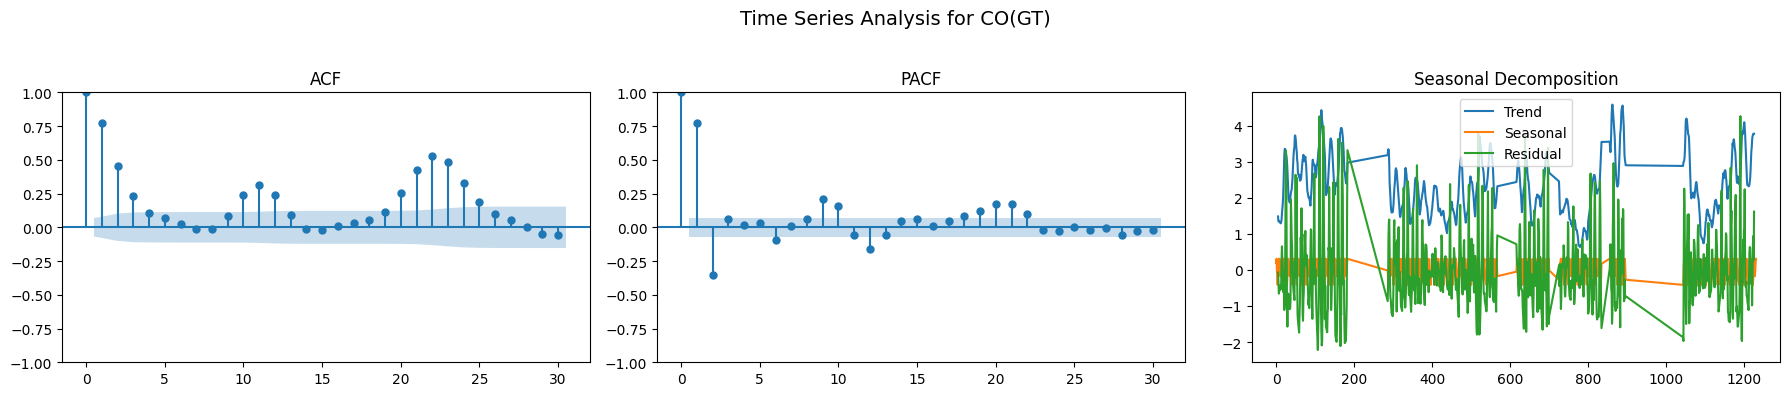

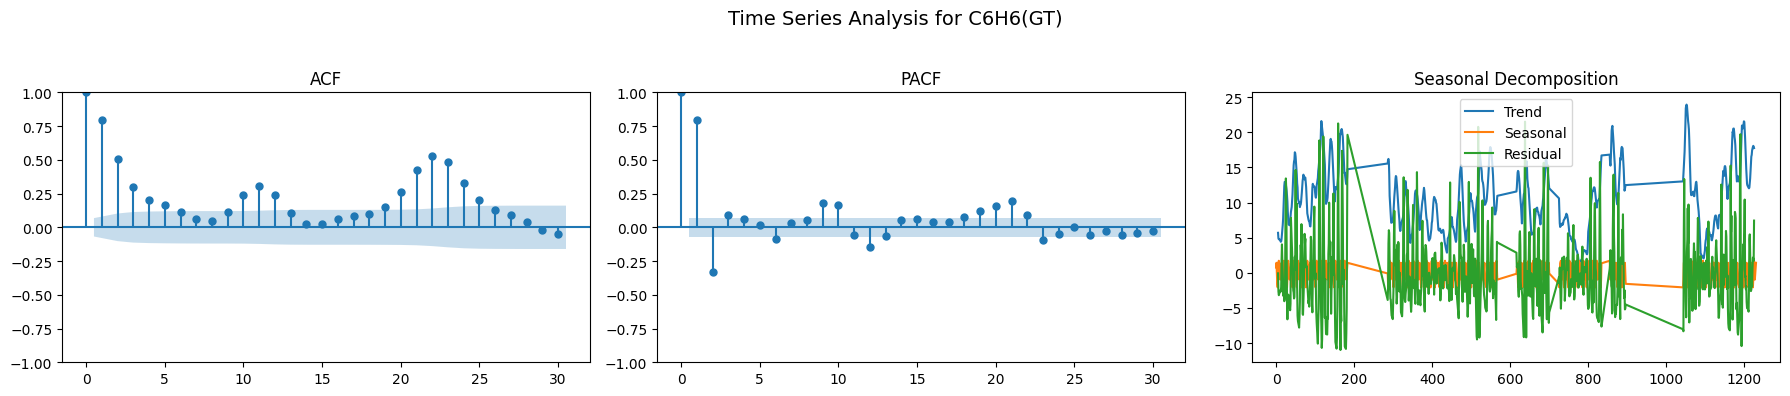

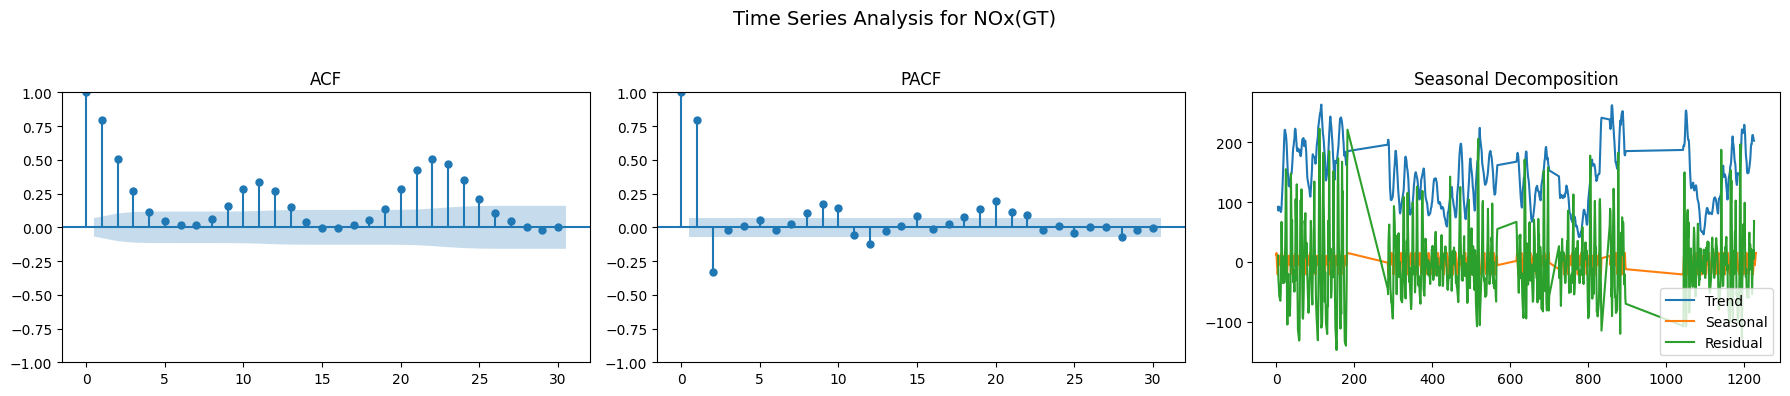

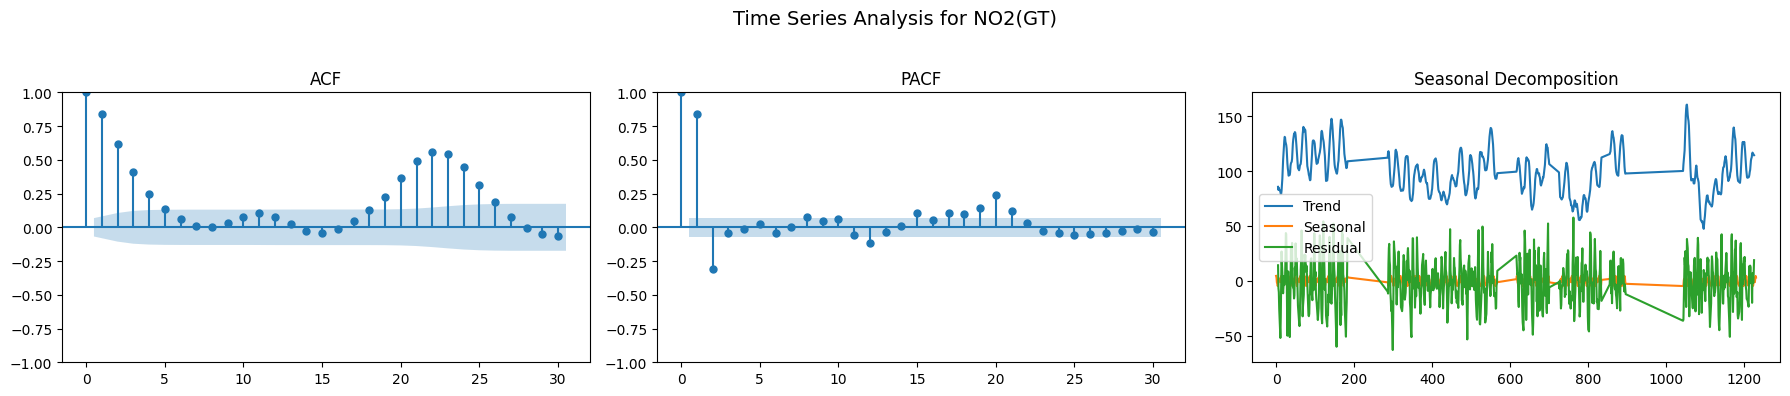

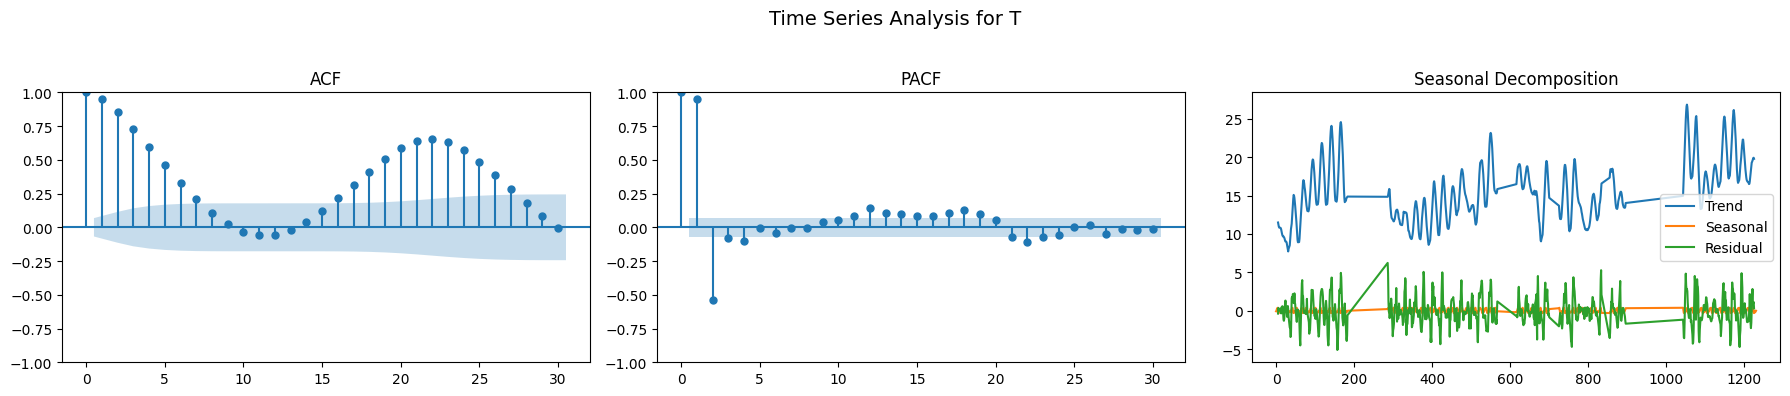

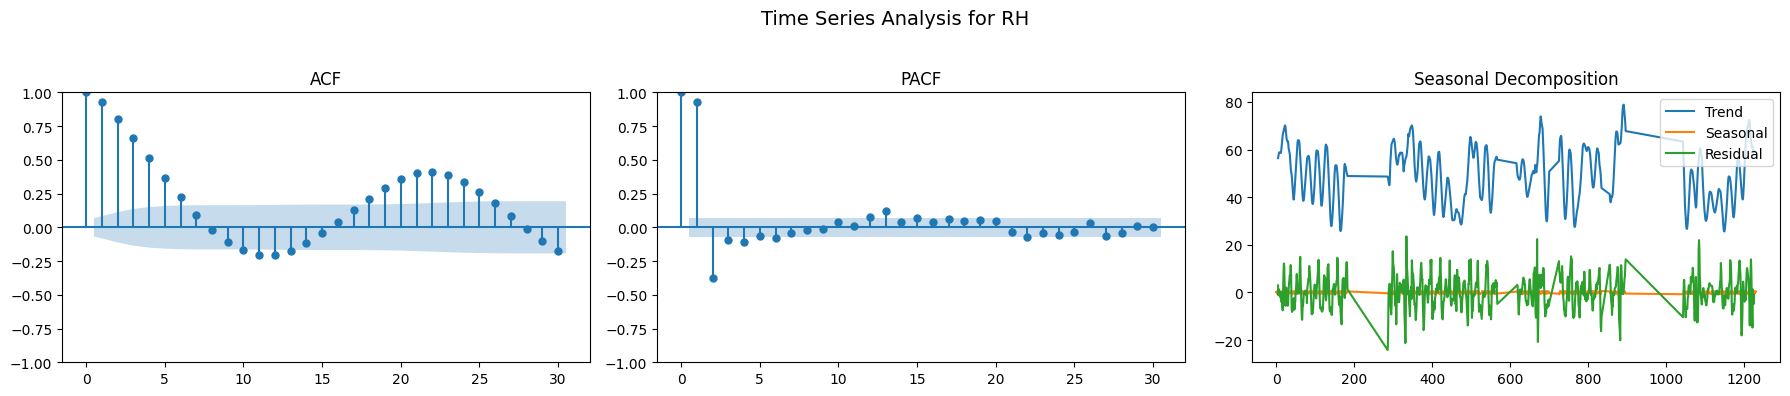

In [11]:
df = df.dropna()
variables = df[keep_cols].columns[1:]
get_seasonal_decomposition(df, variables)

### 1.2. PM2.5 Beijing

In [12]:
df = pd.read_csv(f"{DATASETS_FOLDER}/prsa_beijing.csv")
keep_cols = ["ds", "pm2_5", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]

In [13]:
for col in df.columns:
    perc_rows_missing = round(df[[col]].isnull().any(axis=1).sum() / len(df) * 100, 2)
    print(f"{col}: {100 - perc_rows_missing}%")

ds: 100.0%
pm2_5: 95.28%
DEWP: 100.0%
TEMP: 100.0%
PRES: 100.0%
cbwd: 100.0%
Iws: 100.0%
Is: 100.0%
Ir: 100.0%


In [14]:
print_dataset_summary(df, keep_cols)
df[keep_cols].describe().round(2)

Number of instances: 43824
Time period: 2010-1-1-0 - 2014-12-31-23
Number of rows with at least one missing value: 2067 (4.72)%


pm2_5      DEWP      TEMP      PRES       Iws        Is        Ir
count  41757.00  43824.00  43824.00  43824.00  43824.00  43824.00  43824.00
mean      98.61      1.82     12.45   1016.45     23.89      0.05      0.19
std       92.05     14.43     12.20     10.27     50.01      0.76      1.42
min        0.00    -40.00    -19.00    991.00      0.45      0.00      0.00
25%       29.00    -10.00      2.00   1008.00      1.79      0.00      0.00
50%       72.00      2.00     14.00   1016.00      5.37      0.00      0.00
75%      137.00     15.00     23.00   1025.00     21.91      0.00      0.00
max      994.00     28.00     42.00   1046.00    585.60     27.00     36.00

Estimated dominant period for pm2_5: 10439
Estimated dominant period for DEWP: 8351
Estimated dominant period for TEMP: 8351
Estimated dominant period for PRES: 8351
Estimated dominant period for Iws: 8351
Estimated dominant period for Is: 8351
Estimated dominant period for Ir: 8351


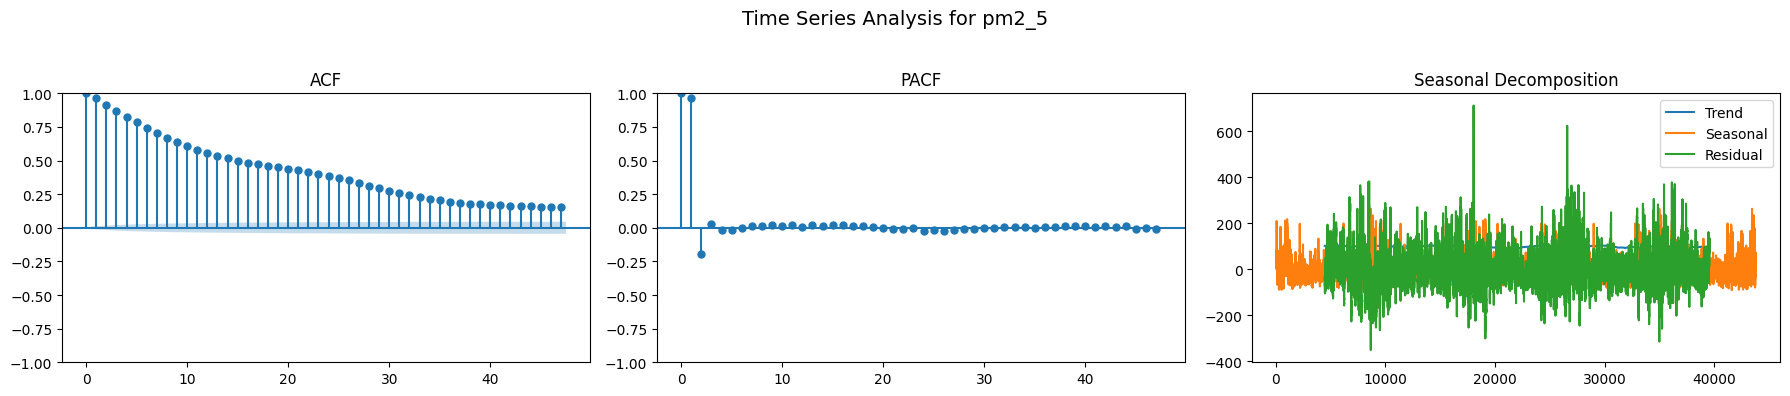

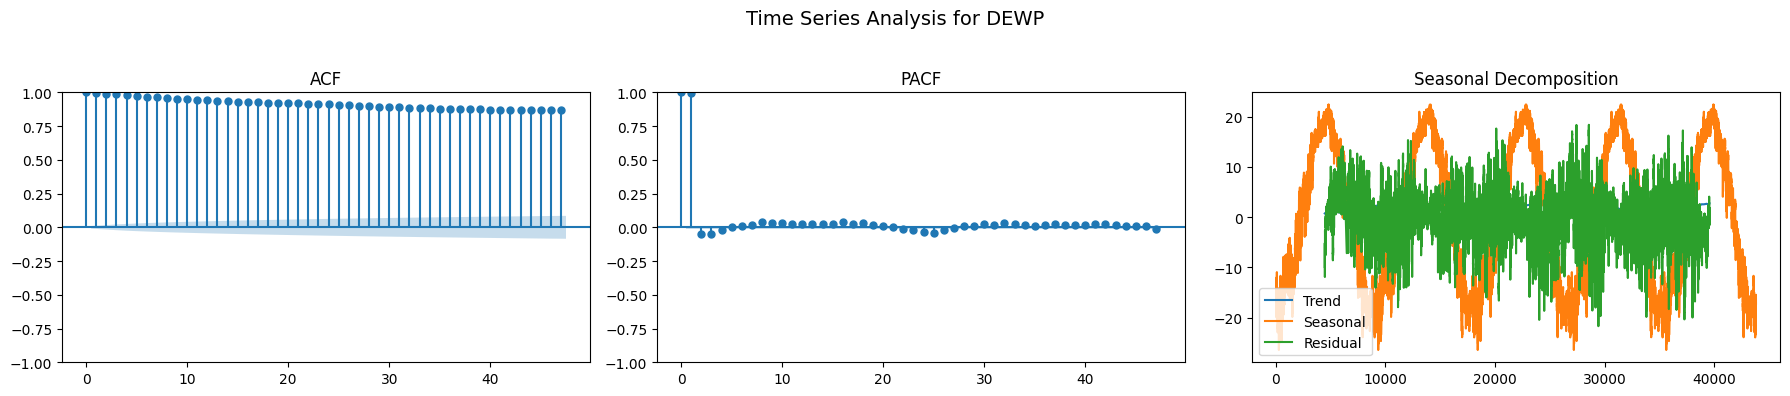

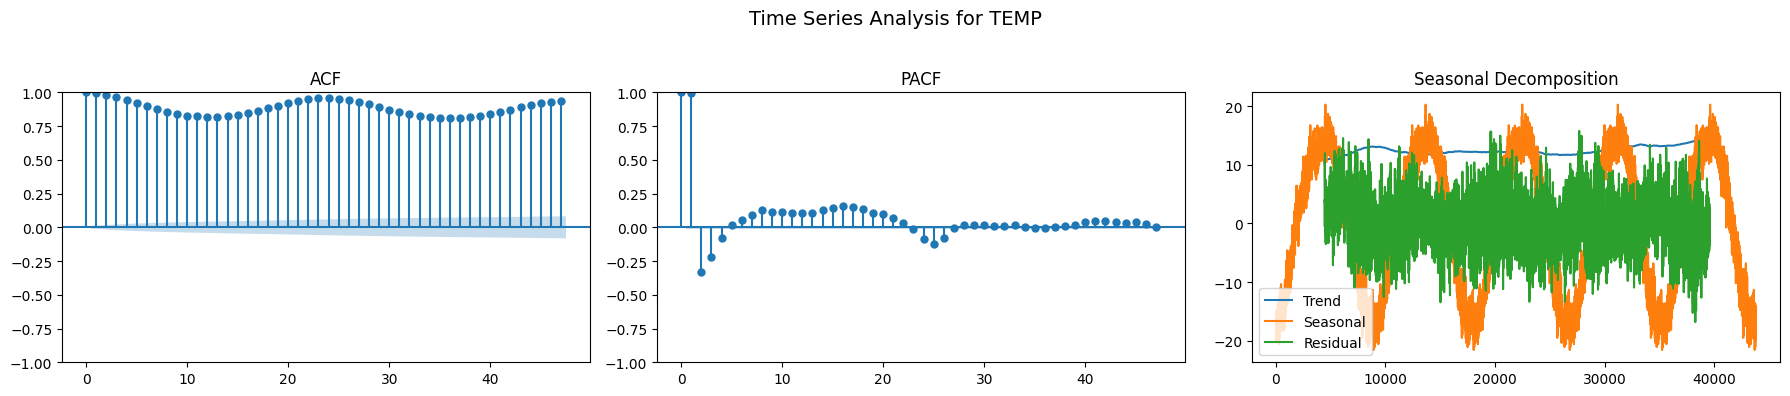

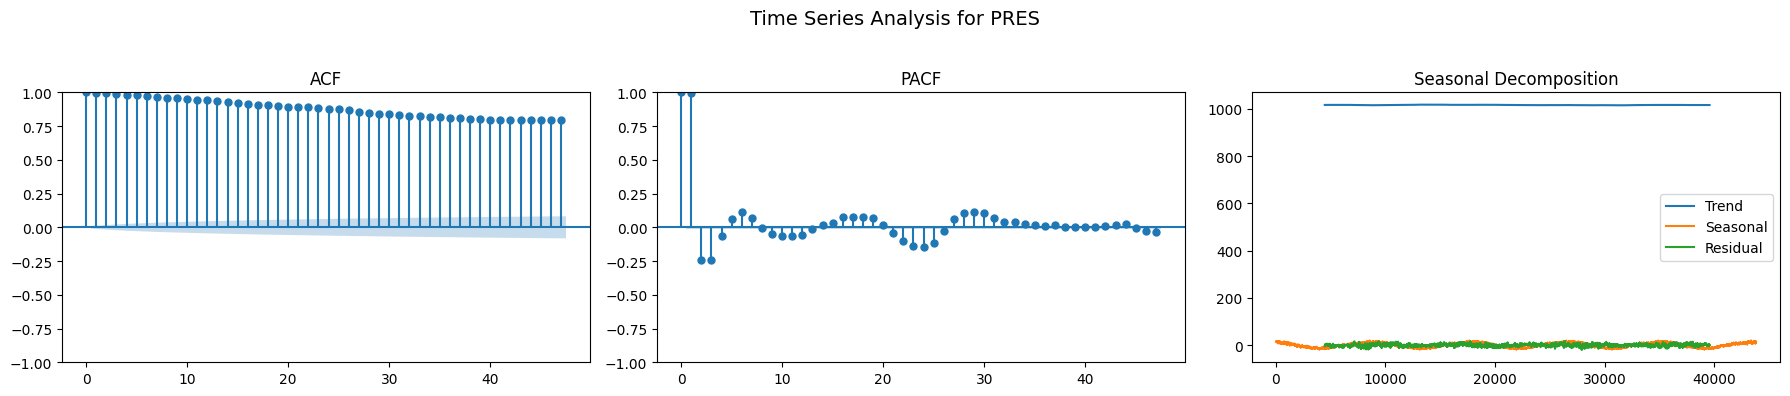

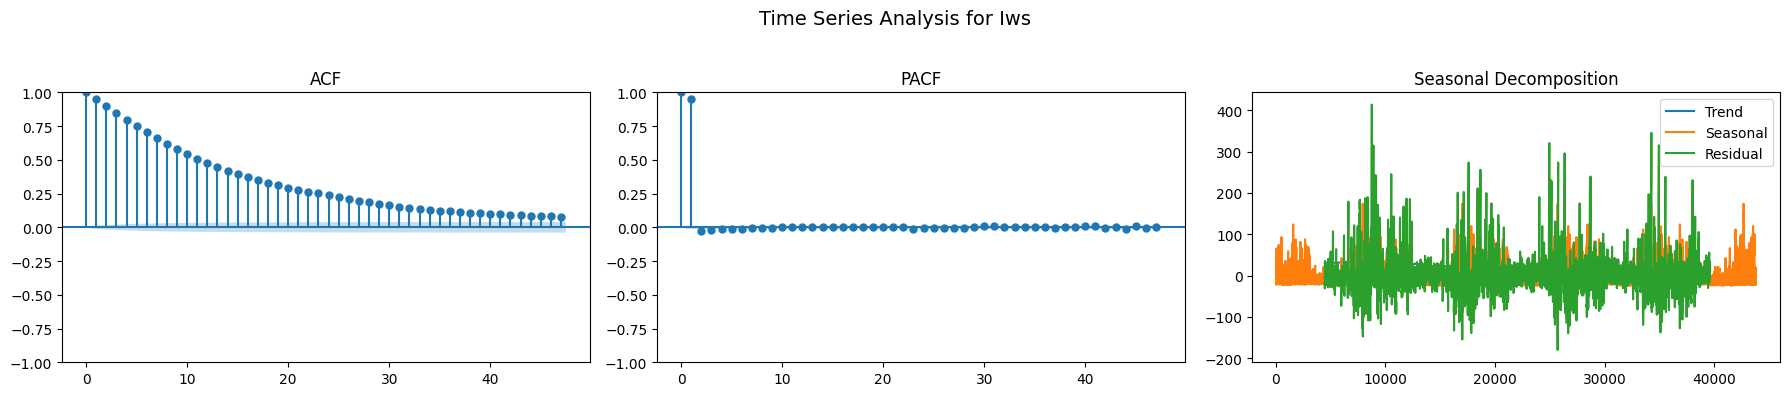

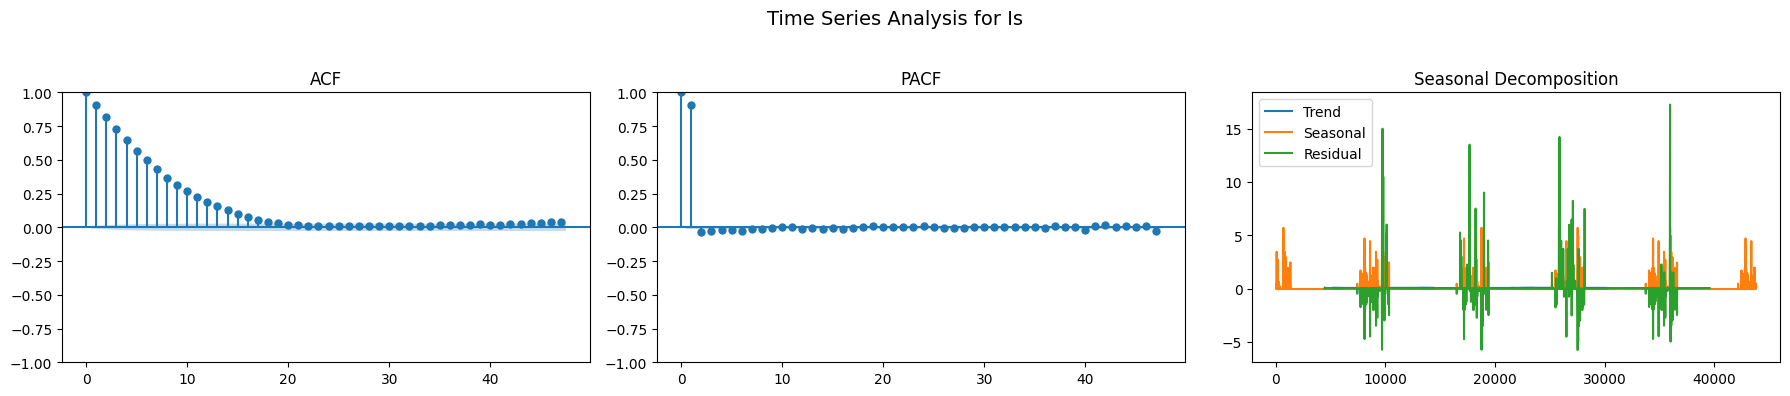

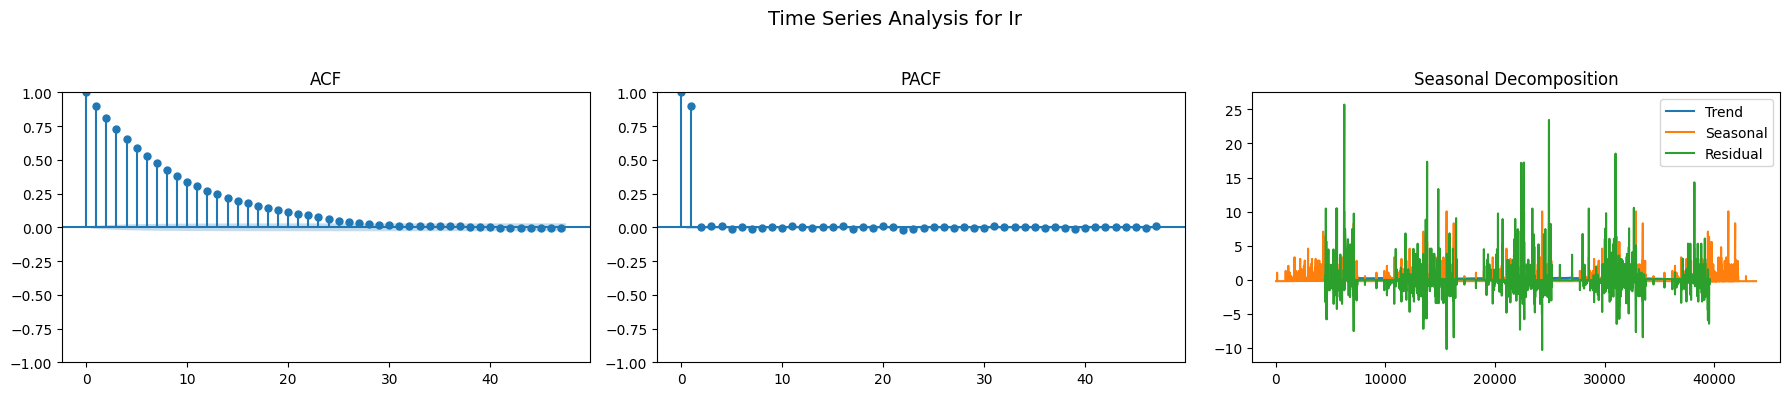

In [15]:
df = df.dropna()
variables = df[keep_cols].columns[1:]
get_seasonal_decomposition(df, variables)

### 1.3. Appliances Energy

In [16]:
df = pd.read_csv(f"{DATASETS_FOLDER}/appliances_energy.csv")
keep_cols = ["ds", "T_out", "Press_mm_hg", "RH_out", "Windspeed", "Visibility", "Tdewpoint"]

In [17]:
for col in df.columns:
    perc_rows_missing = round(df[[col]].isnull().any(axis=1).sum() / len(df) * 100, 2)
    print(f"{col}: {100 - perc_rows_missing}%")

ds: 100.0%
Appliances: 100.0%
lights: 100.0%
T1: 100.0%
RH_1: 100.0%
T2: 100.0%
RH_2: 100.0%
T3: 100.0%
RH_3: 100.0%
T4: 100.0%
RH_4: 100.0%
T5: 100.0%
RH_5: 100.0%
T6: 100.0%
RH_6: 100.0%
T7: 100.0%
RH_7: 100.0%
T8: 100.0%
RH_8: 100.0%
T9: 100.0%
RH_9: 100.0%
T_out: 100.0%
Press_mm_hg: 100.0%
RH_out: 100.0%
Windspeed: 100.0%
Visibility: 100.0%
Tdewpoint: 100.0%
rv1: 100.0%
rv2: 100.0%


In [18]:
print_dataset_summary(df, keep_cols)
df[keep_cols].describe().round(2)

Number of instances: 19735
Time period: 11/01/16 17:00 - 27/05/16 18:00
Number of rows with at least one missing value: 0 (0.0)%


T_out  Press_mm_hg    RH_out  Windspeed  Visibility  Tdewpoint
count  19735.00     19735.00  19735.00   19735.00    19735.00   19735.00
mean       7.41       755.52     79.75       4.04       38.33       3.76
std        5.32         7.40     14.90       2.45       11.79       4.20
min       -5.00       729.30     24.00       0.00        1.00      -6.60
25%        3.67       750.93     70.33       2.00       29.00       0.90
50%        6.92       756.10     83.67       3.67       40.00       3.43
75%       10.40       760.93     91.67       5.50       40.00       6.57
max       26.10       772.30    100.00      14.00       66.00      15.50

Estimated dominant period for T_out: 19735
Estimated dominant period for Press_mm_hg: 6578
Estimated dominant period for RH_out: 144
Estimated dominant period for Windspeed: 1794
Estimated dominant period for Visibility: 658
Estimated dominant period for Tdewpoint: 19735


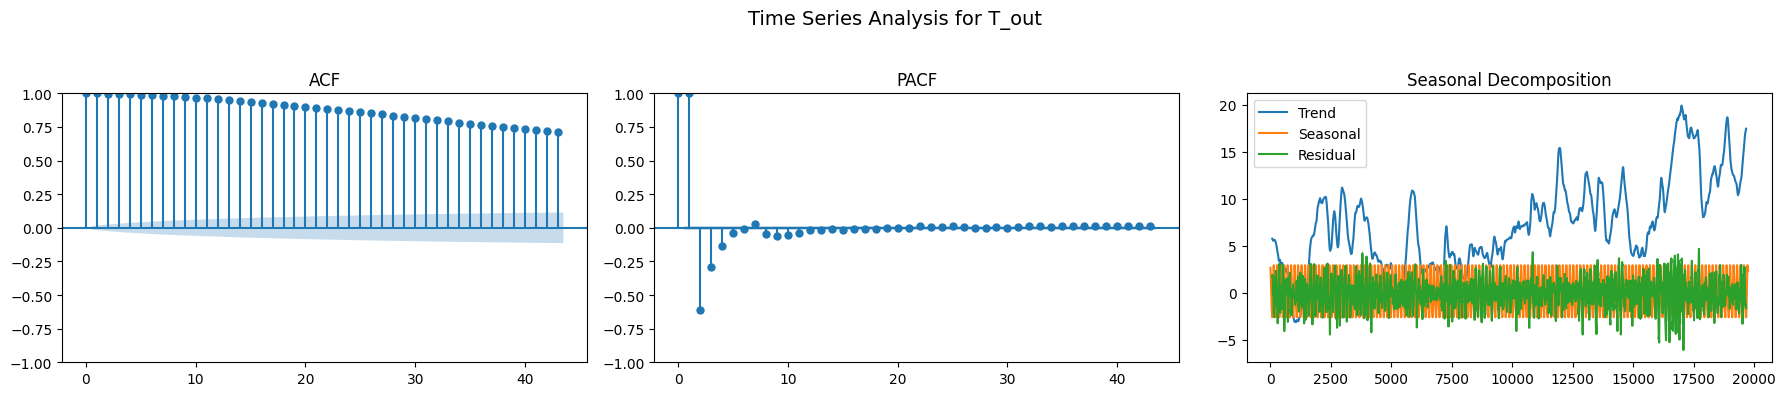

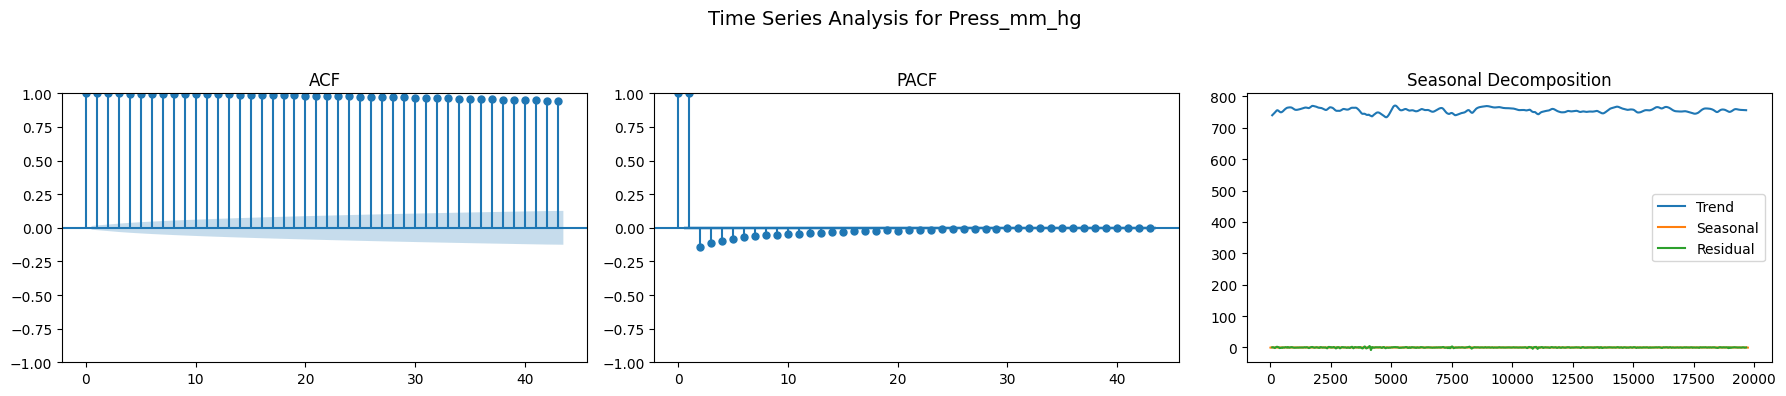

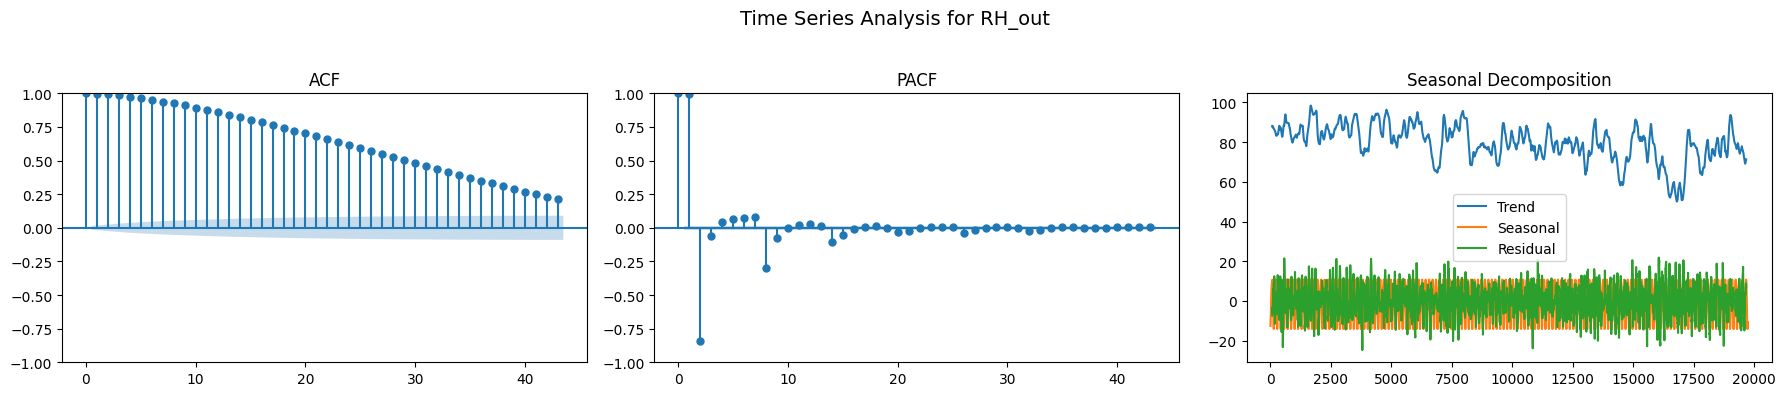

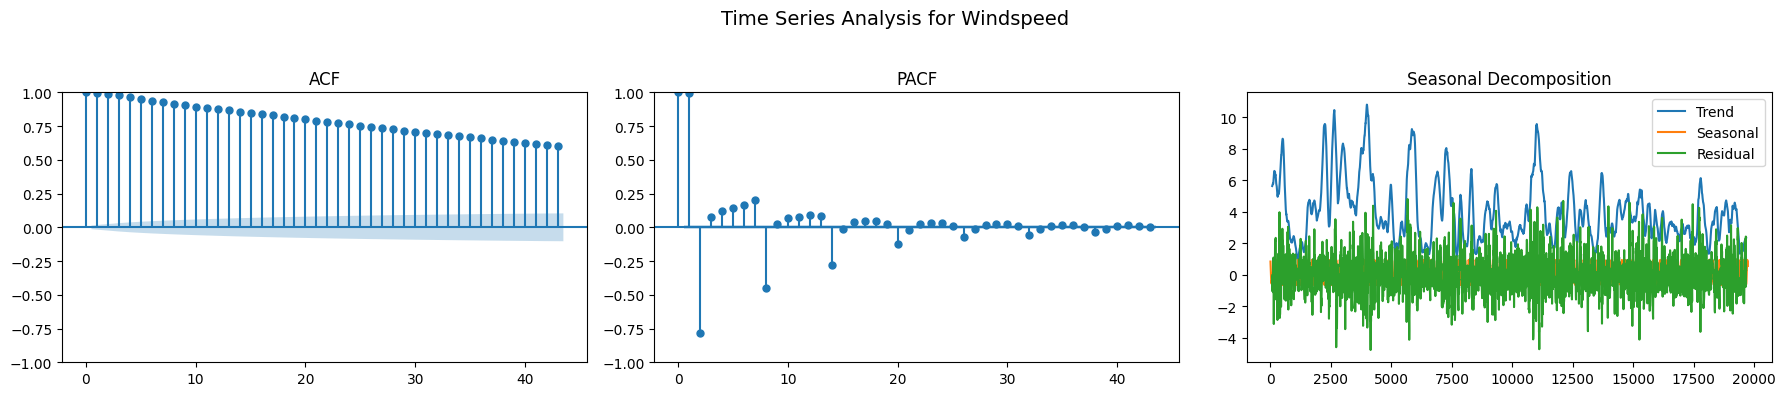

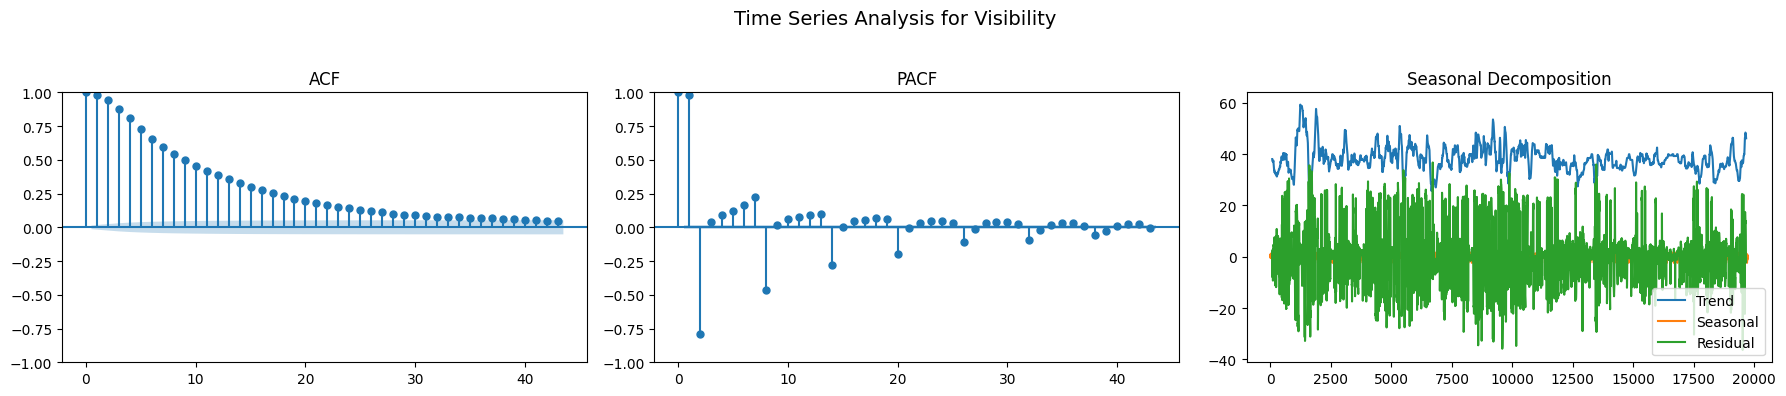

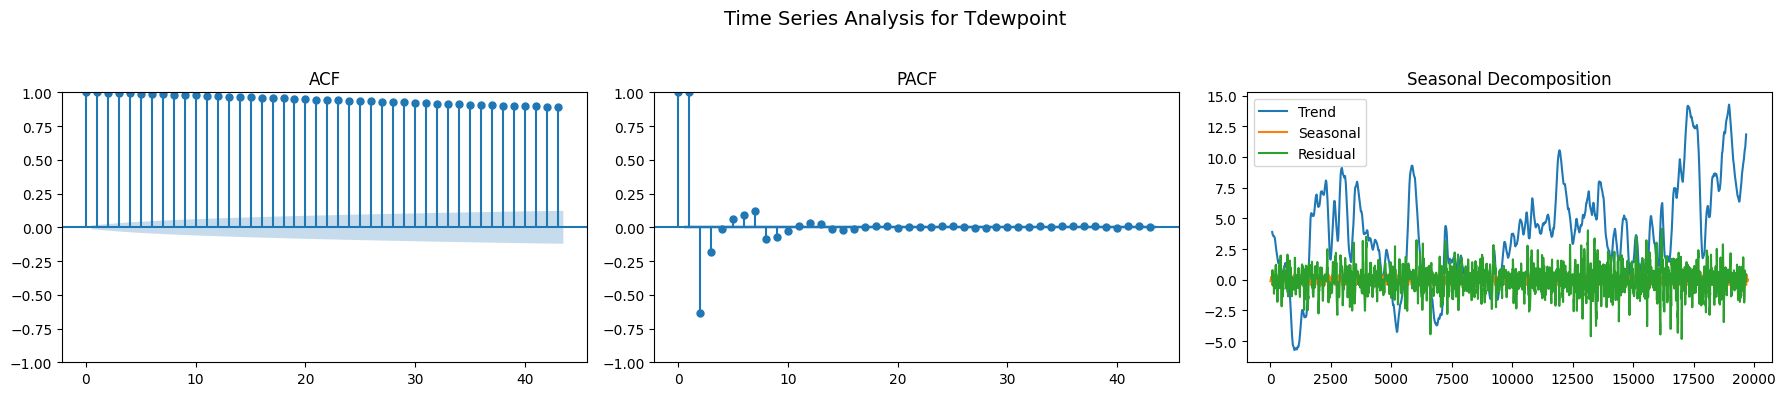

In [19]:
df = df.dropna()
variables = df[keep_cols].columns[1:]
get_seasonal_decomposition(df, variables)

### 1.4. Metro Traffic

In [20]:
df = pd.read_csv(f"{DATASETS_FOLDER}/metro_traffic.csv")
keep_cols = ["ds", "temp", "rain_1h", "clouds_all"]

In [21]:
for col in df.columns:
    perc_rows_missing = round(df[[col]].isnull().any(axis=1).sum() / len(df) * 100, 2)
    print(f"{col}: {100 - perc_rows_missing}%")

ds: 100.0%
holiday: 0.12999999999999545%
temp: 100.0%
rain_1h: 100.0%
snow_1h: 100.0%
clouds_all: 100.0%
weather_main: 100.0%
weather_description: 100.0%
traffic_volume: 100.0%


In [22]:
print_dataset_summary(df, keep_cols)
df[keep_cols].describe().round(2)

Number of instances: 48204
Time period: 02/10/12 09:00 - 30/09/18 23:00
Number of rows with at least one missing value: 0 (0.0)%


temp   rain_1h  clouds_all
count  48204.00  48204.00    48204.00
mean     281.21      0.33       49.36
std       13.34     44.79       39.02
min        0.00      0.00        0.00
25%      272.16      0.00        1.00
50%      282.45      0.00       64.00
75%      291.81      0.00       90.00
max      310.07   9831.30      100.00

Estimated dominant period for temp: 12
Estimated dominant period for rain_1h: 7
Estimated dominant period for clouds_all: 10


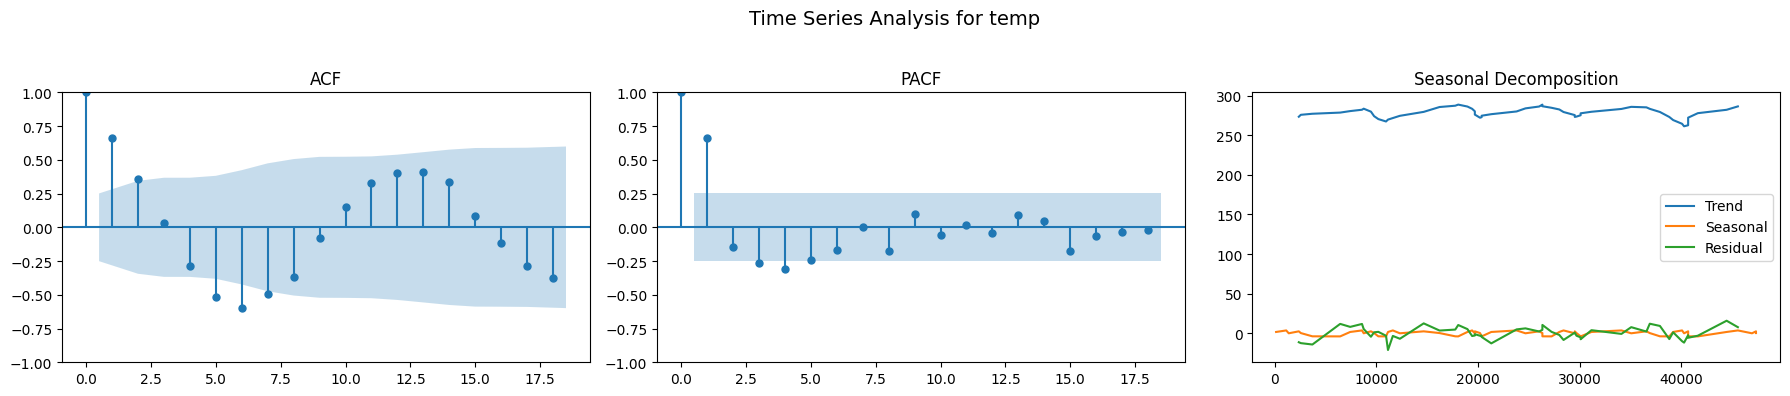

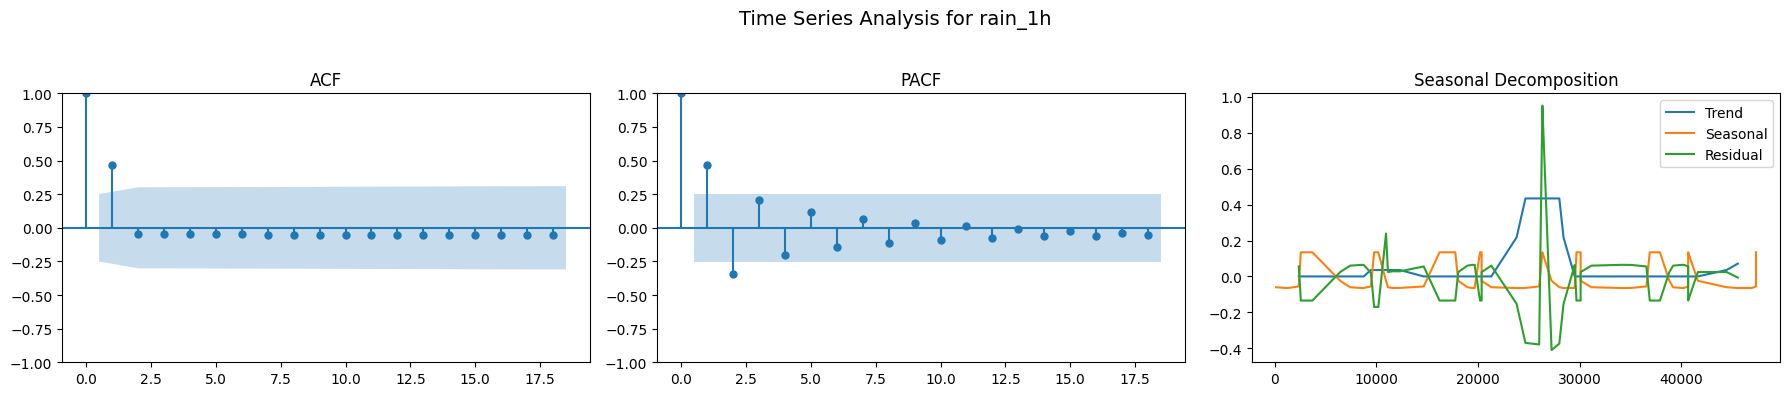

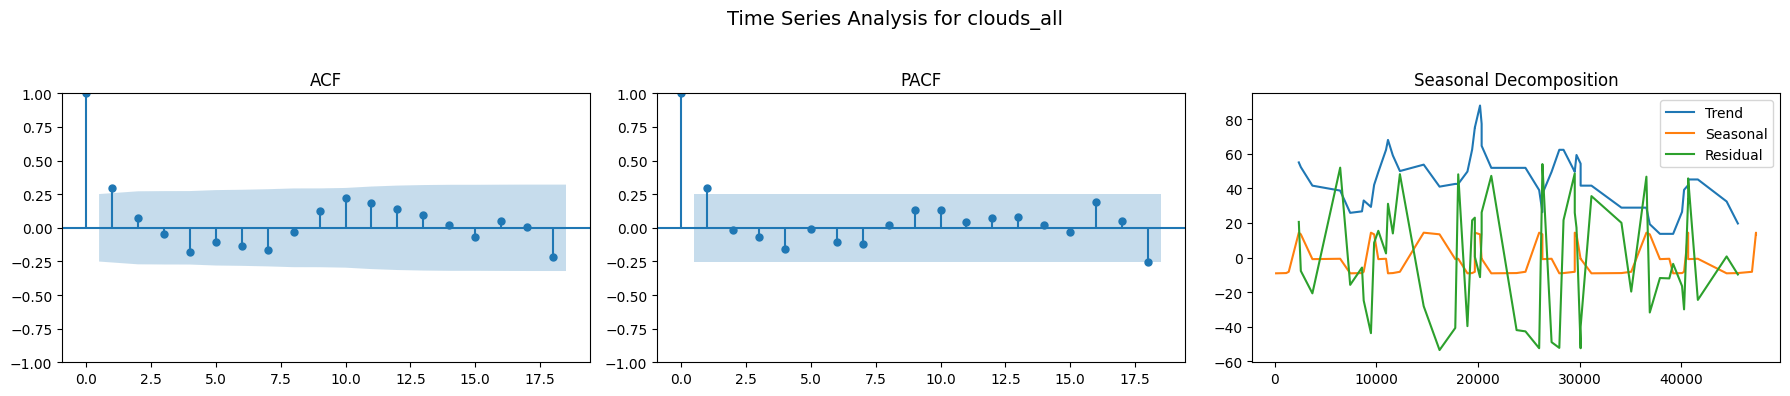

In [23]:
df = df.dropna()
variables = df[keep_cols].columns[1:]
get_seasonal_decomposition(df, variables)

## 2. Individual Results Analysis

In [24]:
DATASETS_NAMES = [
    "UCI_AIR_QUALITY",
    "UCI_PRSA_BEIJING",
    "UCI_APPLIANCES_ENERGY",
    "UCI_METRO_TRAFFIC",
]

RMSE_COL = "Avg_RMSE"
ET_COL = "total_perf_duration"
ET_MIN_COL = "total_perf_duration_minutes"
CHANGE_POINT_PERC_COL = "change_point_perc"
CHANGE_POINT_APPROACH_COL = "change_point_approach"
DATASET_NAME_COL = "dataset_name"

In [25]:
SEEDS = [0, 42, 52, 101, 214] #, 565, 600, 713, 1001]
EXPECTED_NUMBER_APPROACHES = (3 * 7) + 10

In [26]:
def get_df_for_dataset(seed: int, database_name: str, dataset_name: str) -> pd.DataFrame:
    def get_df_for_dataset_inner() -> pd.DataFrame:
        directory_path = f"outputs/report/seed={seed}/{database_name}/{dataset_name}"

        print(f"Reading from {directory_path}")

        metrics_dfs = []
        
        for root, dirs, files in os.walk(directory_path):
            for filename in files:
                if filename.endswith('.json'):
                    file_path = os.path.join(root, filename)
                    
                    try:
                        with open(file_path, 'r') as file:
                            data = json.load(file)
                            metrics_dfs.append(
                                pd.DataFrame({
                                    'change_point_method': [data.get('change_point_method', np.nan)],
                                    'change_point_cost_function': [data.get('change_point_cost_function', np.nan)],
                                    'change_point_approach': [data.get('change_point_approach', np.nan)],
                                    'change_point_perc': [data.get('change_point_perc', np.nan)],
                                    'detect_change_point_duration': [data.get('detect_change_point_perf_duration', np.nan)],
                                    'detect_change_point_duration_minutes': [data.get('detect_change_point_perf_duration', np.nan) / 60],
                                    'tuner_duration': [data.get('tuner_perf_duration', np.nan)],
                                    'tuner_duration_minutes': [data.get('tuner_perf_duration', np.nan) / 60],
                                    'retrain_duration': [data.get('retrain_perf_duration', np.nan)],
                                    'retrain_duration_minutes': [data.get('retrain_perf_duration', np.nan) / 60],
                                    'forecasting_test_duration': [data.get('forecasting_test_perf_duration', np.nan)],
                                    'forecasting_test_duration_minutes': [data.get('forecasting_test_perf_duration', np.nan) / 60],
                                    'total_duration': [data.get('total_time_duration', np.nan)],
                                    'total_duration_minutes': [data.get('total_time_duration', np.nan) / 60],
                                    'total_perf_duration': [data.get('total_perf_duration', np.nan)],
                                    'total_perf_duration_minutes': [data.get('total_perf_duration', np.nan) / 60],
                                    'total_process_duration': [data.get('total_process_duration', np.nan)],
                                    'total_process_duration_minutes': [data.get('total_process_duration', np.nan) / 60],
                                    'Avg_MAPE': [data.get('error_results', {}).get('Avg_MAPE', np.nan)],
                                    'Avg_MAE': [data.get('error_results', {}).get('Avg_MAE', np.nan)],
                                    'Avg_MSE': [data.get('error_results', {}).get('Avg_MSE', np.nan)],
                                    'Avg_RMSE': [data.get('error_results', {}).get('Avg_RMSE', np.nan)],
                                    'Avg_R2':  [data.get('error_results', {}).get('Avg_R2', np.nan)],
                                }))
                    except KeyError as e:
                        print(f"Error in {file_path}: {e}")
                        continue
                    
        metrics_df = pd.concat(metrics_dfs, axis=0)
    
        replacements = {
            'Rbf': 'RBF',
            ' Ar': ' AR',
            'Bin_Seg': 'BinSeg',
            'Bottom_Up': 'BottomUp',
            'Fixed_Perc Fixed_Cut_0.0': 'Full',
            'Fixed_Perc Fixed_Cut_': 'Fixed Cut ',
            '0.1': '10%',
            '0.2': '20%',
            '0.3': '30%',
            '0.4': '40%',
            '0.5': '50%',
            '0.6': '60%',
            '0.7': '70%',
            '0.8': '80%',
            '0.9': '90%',
        }
        for old, new in replacements.items():
            metrics_df['change_point_approach'] = metrics_df['change_point_approach'].str.replace(old, new)

        return metrics_df

    metrics_df = get_df_for_dataset_inner()
    metrics_cols = metrics_df.columns.tolist()
    metrics_df['database'] = [database_name] * len(metrics_df)
    metrics_df['dataset'] = [dataset_name] * len(metrics_df)
    metrics_df = metrics_df[['database', 'dataset'] + metrics_cols]

    return metrics_df.reset_index(drop=True)


def highlight_rows(row):
    approach = row['change_point_approach']
    if isinstance(approach, str):
        if 'Fixed' in approach:
            return ['background-color: darkslateblue'] * len(row)
        elif approach == 'Full':
            return ['background-color: darkgoldenrod'] * len(row)
        elif 'Window' in approach:
            return ['background-color: darkmagenta'] * len(row)
        elif 'BottomUp' in approach:
            return ['background-color: darkolivegreen'] * len(row)
        elif 'BinSeg' in approach:
            return ['background-color: teal'] * len(row)
    return [''] * len(row)

In [27]:
def get_individual_results(datasets_dict, dataset_name):
    relevant_metrics = [CHANGE_POINT_PERC_COL, RMSE_COL, ET_COL, ET_MIN_COL]
    concat_df = None        
    for seed in datasets_dict[dataset_name].keys():
        df = datasets_dict[dataset_name][seed].copy()
        df[DATASET_NAME_COL] = dataset_name
        df = df[[DATASET_NAME_COL, CHANGE_POINT_APPROACH_COL] + relevant_metrics]
        df = df.rename(columns={
            CHANGE_POINT_PERC_COL: f"{CHANGE_POINT_PERC_COL}_seed_{seed}",
            RMSE_COL: f"{RMSE_COL}_seed_{seed}",
            ET_COL: f"{ET_COL}_seed_{seed}",
            ET_MIN_COL: f"{ET_MIN_COL}_seed_{seed}",
        })
        if concat_df is None:
            concat_df = df
        else:
            concat_df = pd.merge(concat_df, df, on=[DATASET_NAME_COL, CHANGE_POINT_APPROACH_COL], how='left')

    for metric in relevant_metrics:
        metric_cols = [col for col in concat_df.columns if f"{metric}_seed_" in col]
        if metric_cols:
            concat_df[f"{metric}_mean"] = concat_df[metric_cols].mean(axis=1, skipna=True)
            concat_df[f"{metric}_std"] = concat_df[metric_cols].std(axis=1, skipna=True)

    concat_df = concat_df.round(2).sort_values(by=CHANGE_POINT_APPROACH_COL)
    concat_df.to_excel(f"{OUTPUT_FOLDER}/{dataset_name}_Results.xlsx")
    return concat_df

In [28]:
datasets_dict = {}
for dataset_name in DATASETS_NAMES:
    datasets_dict[dataset_name] = {}

In [29]:
individual_metrics_dict = {}
for dataset_name in DATASETS_NAMES:
    individual_metrics_dict[dataset_name] = None

### 2.1. [UCI] Air Quality

In [30]:
database_name = "UCI"
dataset_name = "AIR_QUALITY"
full_dataset_name = f"{database_name}_{dataset_name}"
for seed in SEEDS:
    df = get_df_for_dataset(seed, database_name, dataset_name)
    assert not df[CHANGE_POINT_APPROACH_COL].duplicated().any(), f"[SEED {seed}] Duplicate values found in column 'change_point_approach'"
    assert len(df) == EXPECTED_NUMBER_APPROACHES, f"[SEED {seed}] Expected {EXPECTED_NUMBER_APPROACHES} lines but got {len(df)}"
    datasets_dict[full_dataset_name][seed] = df
individual_metrics_dict[full_dataset_name] = get_individual_results(datasets_dict, full_dataset_name)
individual_metrics_dict[full_dataset_name].style.apply(highlight_rows, axis=1).format(precision=2)

Reading from outputs/report/seed=0/UCI/AIR_QUALITY
Reading from outputs/report/seed=42/UCI/AIR_QUALITY
Reading from outputs/report/seed=52/UCI/AIR_QUALITY
Reading from outputs/report/seed=101/UCI/AIR_QUALITY
Reading from outputs/report/seed=214/UCI/AIR_QUALITY


### 2.2. [UCI] PM2.5 BEIJING

In [31]:
database_name = "UCI"
dataset_name = "PRSA_BEIJING"
full_dataset_name = f"{database_name}_{dataset_name}"
for seed in SEEDS:
    df = get_df_for_dataset(seed, database_name, dataset_name)
    assert not df[CHANGE_POINT_APPROACH_COL].duplicated().any(), f"[SEED {seed}] Duplicate values found in column 'change_point_approach'"
    assert len(df) == EXPECTED_NUMBER_APPROACHES, f"[SEED {seed}] Expected {EXPECTED_NUMBER_APPROACHES} lines but got {len(df)}"
    datasets_dict[full_dataset_name][seed] = df
individual_metrics_dict[full_dataset_name] = get_individual_results(datasets_dict, full_dataset_name)
individual_metrics_dict[full_dataset_name].style.apply(highlight_rows, axis=1).format(precision=2)

Reading from outputs/report/seed=0/UCI/PRSA_BEIJING
Reading from outputs/report/seed=42/UCI/PRSA_BEIJING
Reading from outputs/report/seed=52/UCI/PRSA_BEIJING
Reading from outputs/report/seed=101/UCI/PRSA_BEIJING
Reading from outputs/report/seed=214/UCI/PRSA_BEIJING


### 2.3. [UCI] Appliances Energy

In [32]:
database_name = "UCI"
dataset_name = "APPLIANCES_ENERGY"
full_dataset_name = f"{database_name}_{dataset_name}"
for seed in SEEDS:
    df = get_df_for_dataset(seed, database_name, dataset_name)
    assert not df[CHANGE_POINT_APPROACH_COL].duplicated().any(), f"[SEED {seed}] Duplicate values found in column 'change_point_approach'"
    assert len(df) == EXPECTED_NUMBER_APPROACHES, f"[SEED {seed}] Expected {EXPECTED_NUMBER_APPROACHES} lines but got {len(df)}"
    datasets_dict[full_dataset_name][seed] = df
individual_metrics_dict[full_dataset_name] = get_individual_results(datasets_dict, full_dataset_name)
individual_metrics_dict[full_dataset_name].style.apply(highlight_rows, axis=1).format(precision=2)

Reading from outputs/report/seed=0/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=42/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=52/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=101/UCI/APPLIANCES_ENERGY
Reading from outputs/report/seed=214/UCI/APPLIANCES_ENERGY


### 2.4. [UCI] Metro Traffic

In [33]:
database_name = "UCI"
dataset_name = "METRO_TRAFFIC"
full_dataset_name = f"{database_name}_{dataset_name}"
for seed in SEEDS:
    df = get_df_for_dataset(seed, database_name, dataset_name)
    assert not df[CHANGE_POINT_APPROACH_COL].duplicated().any(), f"[SEED {seed}] Duplicate values found in column 'change_point_approach'"
    assert len(df) == EXPECTED_NUMBER_APPROACHES, f"[SEED {seed}] Expected {EXPECTED_NUMBER_APPROACHES} lines but got {len(df)}"
    datasets_dict[full_dataset_name][seed] = df
individual_metrics_dict[full_dataset_name] = get_individual_results(datasets_dict, full_dataset_name)
individual_metrics_dict[full_dataset_name].style.apply(highlight_rows, axis=1).format(precision=2)

Reading from outputs/report/seed=0/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=42/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=52/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=101/UCI/METRO_TRAFFIC
Reading from outputs/report/seed=214/UCI/METRO_TRAFFIC


## 3. Plot Change Points

In [34]:
def plot_change_points(df, variables, cpds, filename=None):
    fig, axes = plt.subplots(len(variables), 1, figsize=(12, 3 * len(variables)), sharex=True)

    for i, (variable, ax) in enumerate(zip(variables, axes)):
        ax.plot(df.index, df[variable], linewidth=1)
        for j, cp in enumerate(cpds):
            cp = int(len(df) * cp / 100)
            ax.axvline(
                x=df.index[cp],
                color='red',
                linestyle='--',
                linewidth=1,
                label='Detected Change Point' if j == 0 else None
            )
        ax.set_ylabel(variable, rotation=0, ha='right', va='center')
        ax.set_title(variable.title(), fontsize=12)
        ax.legend(loc='upper right')

    plt.tight_layout()

    if filename:
        plt.savefig(f"{OUTPUT_FOLDER}/{filename}", dpi=300, bbox_inches='tight')

    plt.show()

### 3.1. [UCI] Air Quality

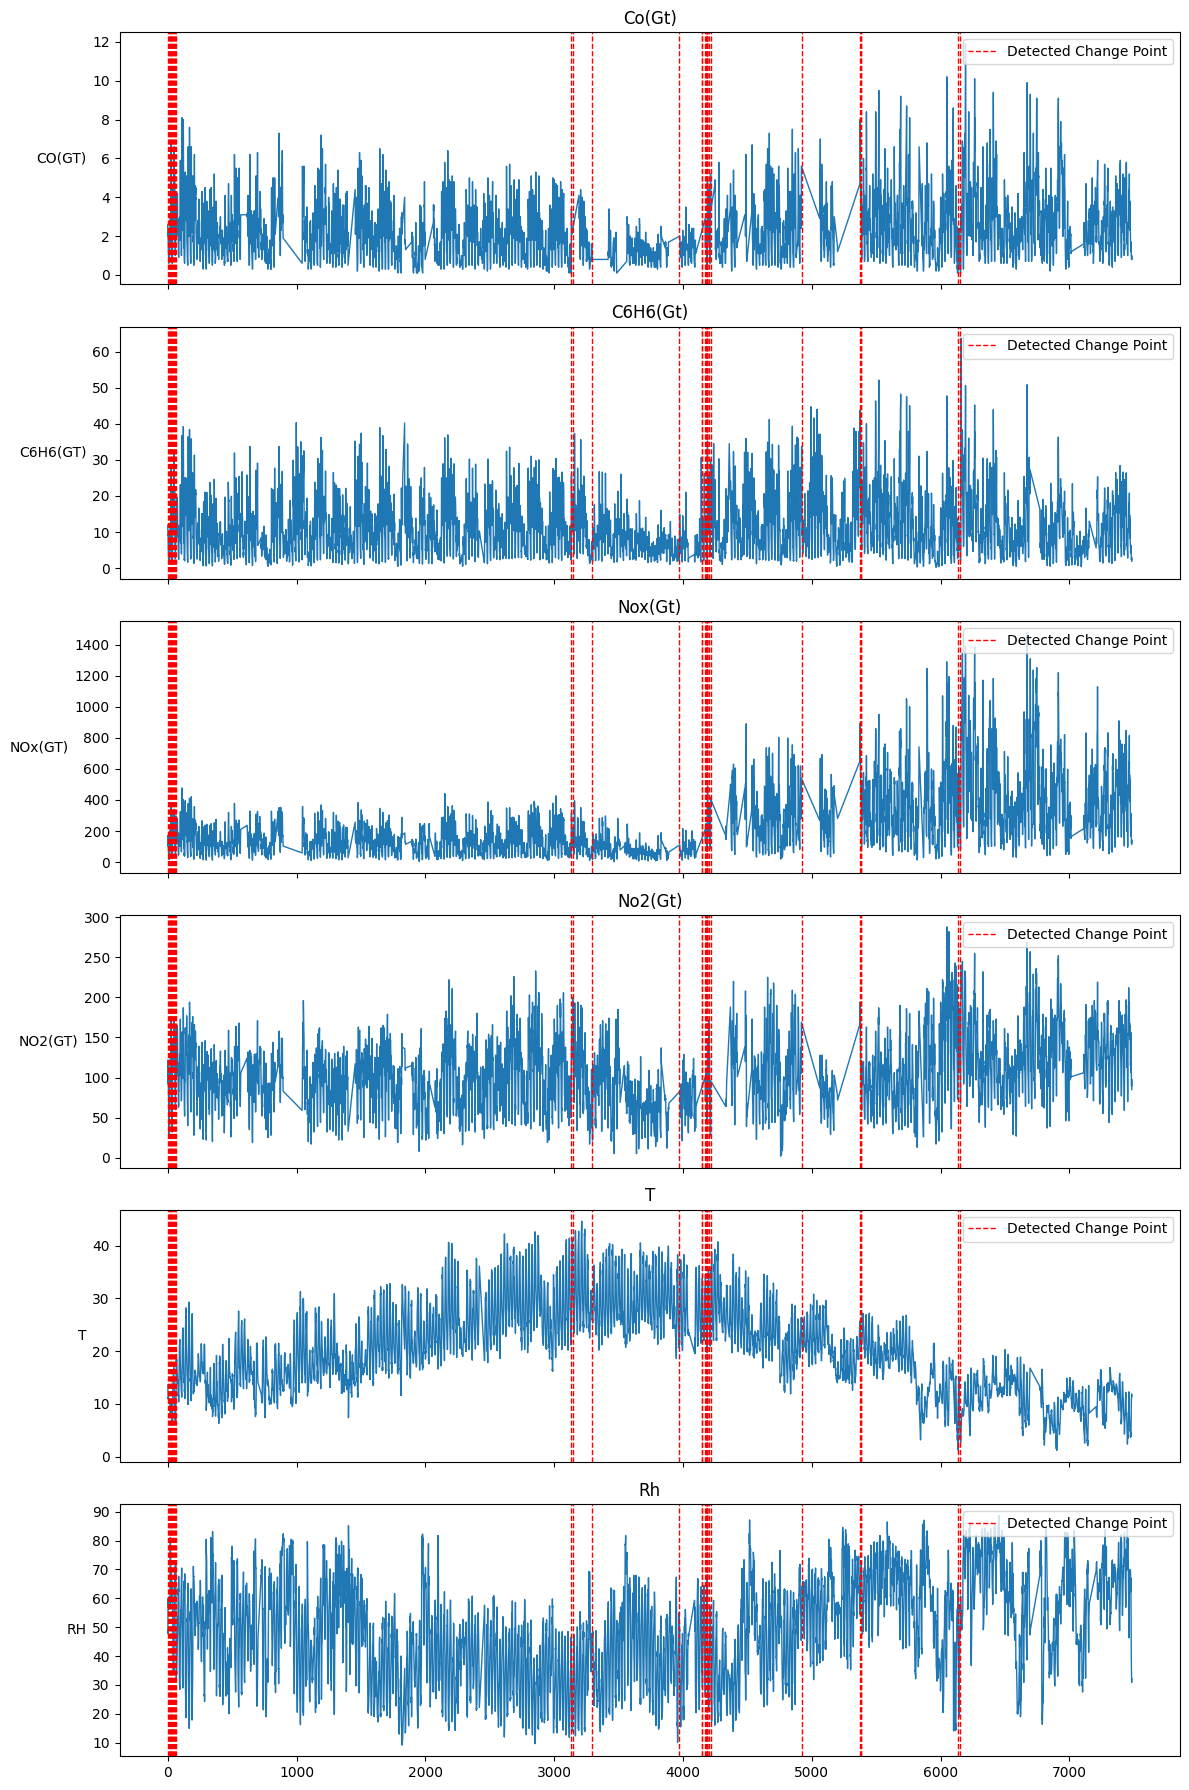

In [35]:
database_name = "UCI"
dataset_name = "AIR_QUALITY"
full_dataset_name = f"{database_name}_{dataset_name}"

df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

cpds = individual_metrics_dict[full_dataset_name][f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}"].to_list()

plot_change_points(df, variables, cpds, f"{full_dataset_name}_change_points.png")

### 3.2. [UCI] PM2.5 BEIJING

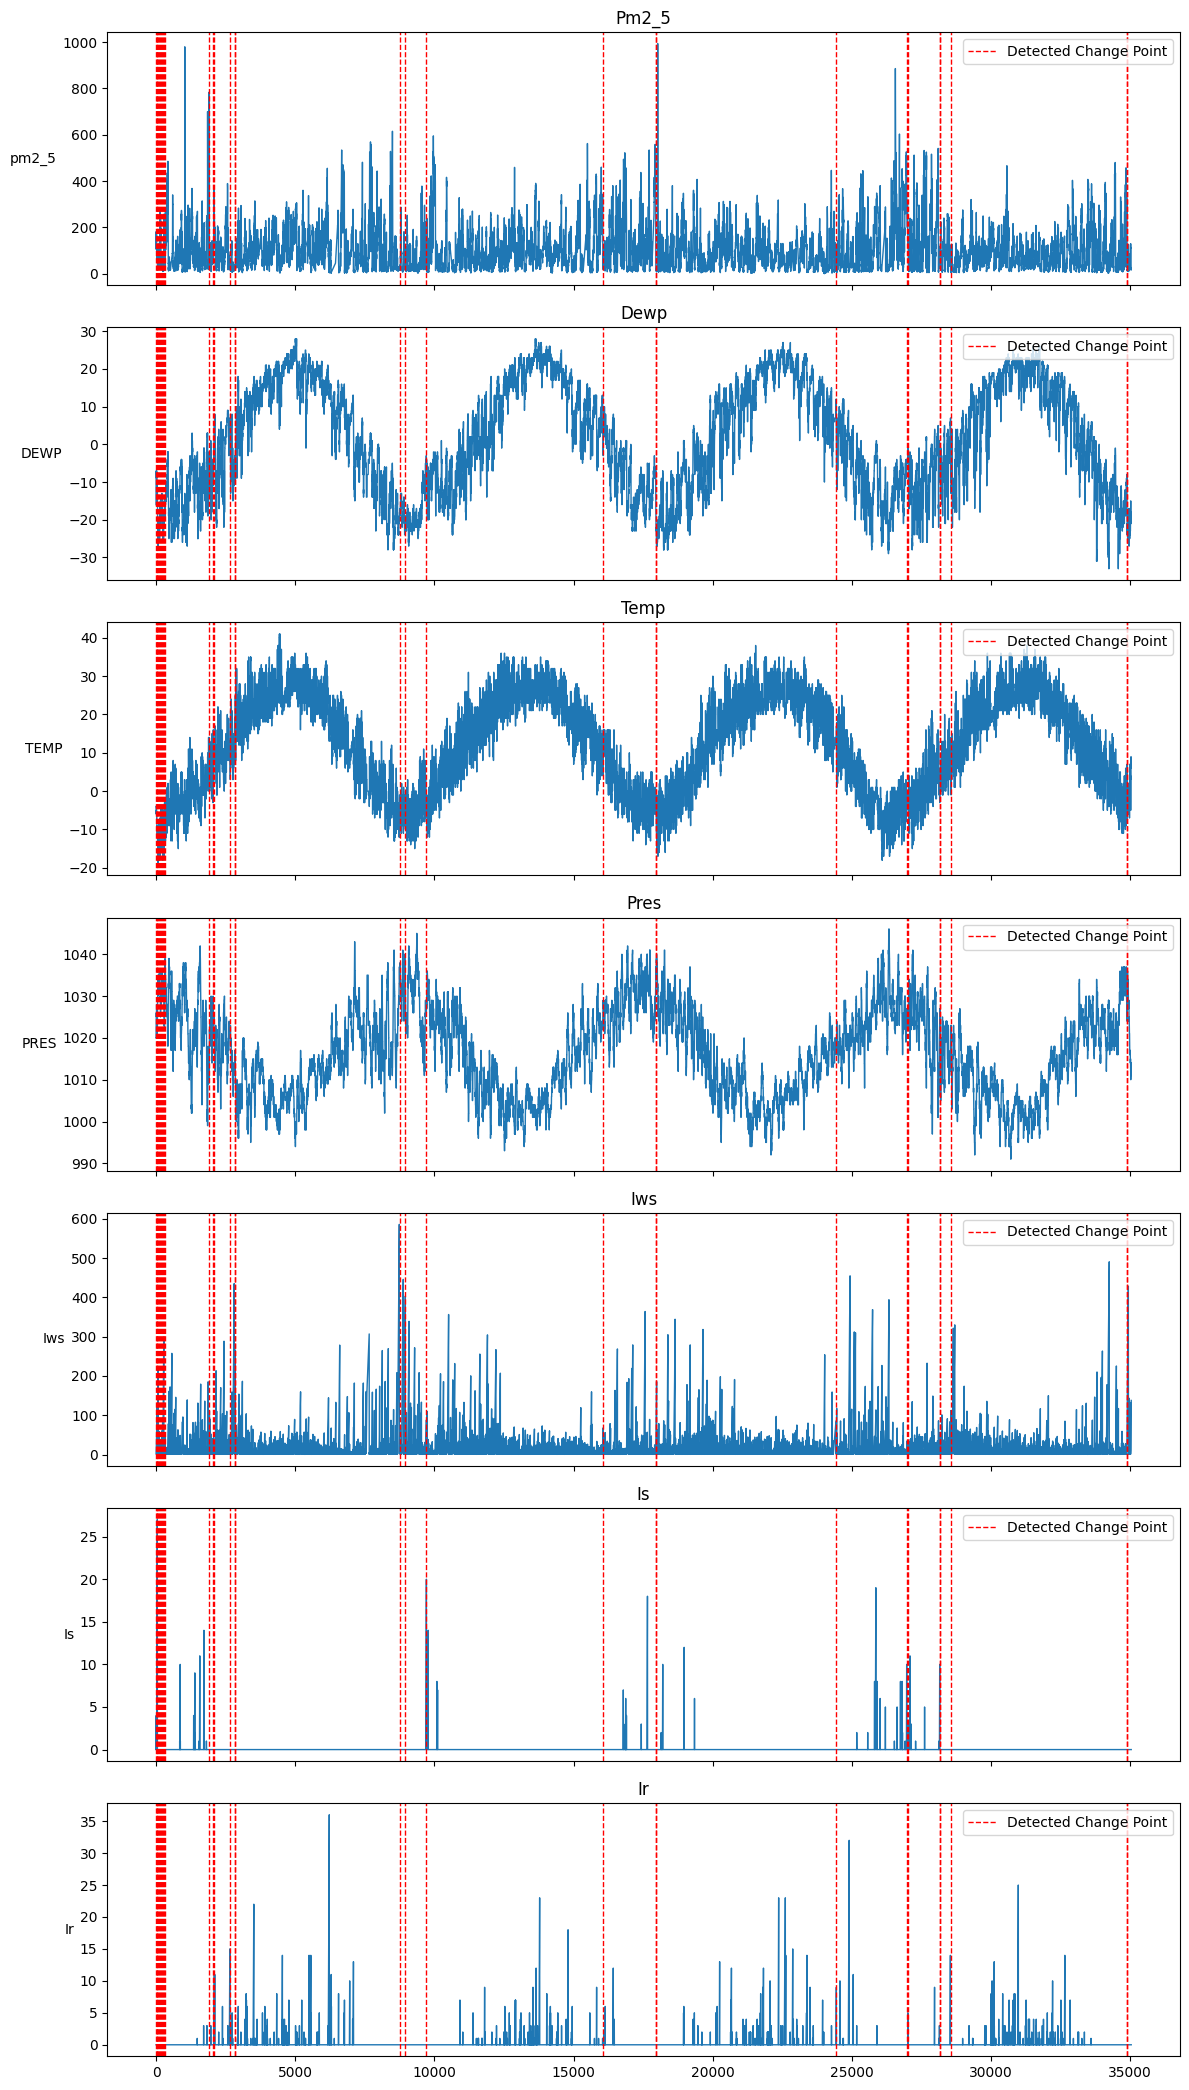

In [36]:
database_name = "UCI"
dataset_name = "PRSA_BEIJING"
full_dataset_name = f"{database_name}_{dataset_name}"

df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

cpds = individual_metrics_dict[full_dataset_name][f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}"].to_list()

plot_change_points(df, variables, cpds, f"{full_dataset_name}_change_points.png")

### 3.3. [UCI] Appliances Energy

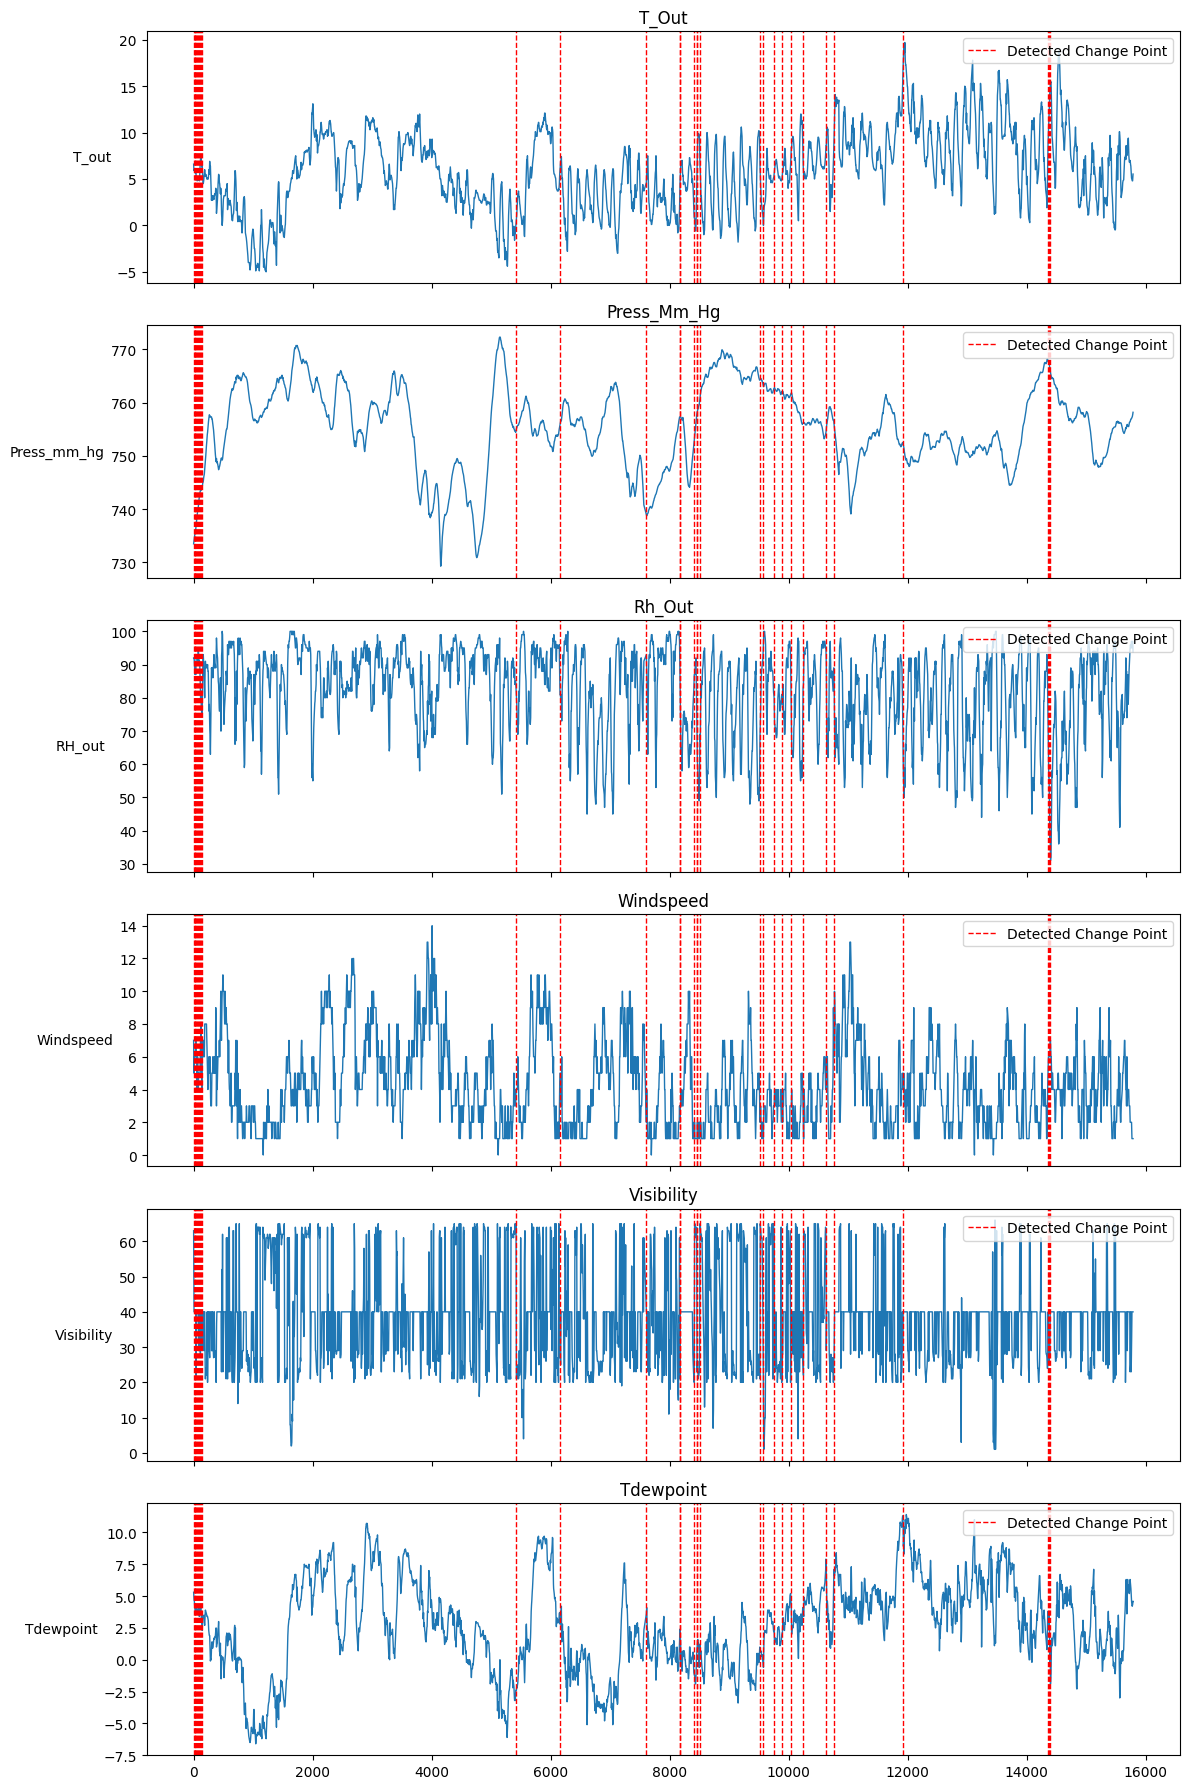

In [37]:
database_name = "UCI"
dataset_name = "APPLIANCES_ENERGY"
full_dataset_name = f"{database_name}_{dataset_name}"

df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

cpds = individual_metrics_dict[full_dataset_name][f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}"].to_list()

plot_change_points(df, variables, cpds, f"{full_dataset_name}_change_points.png")

### 3.4. [UCI] Metro Traffic

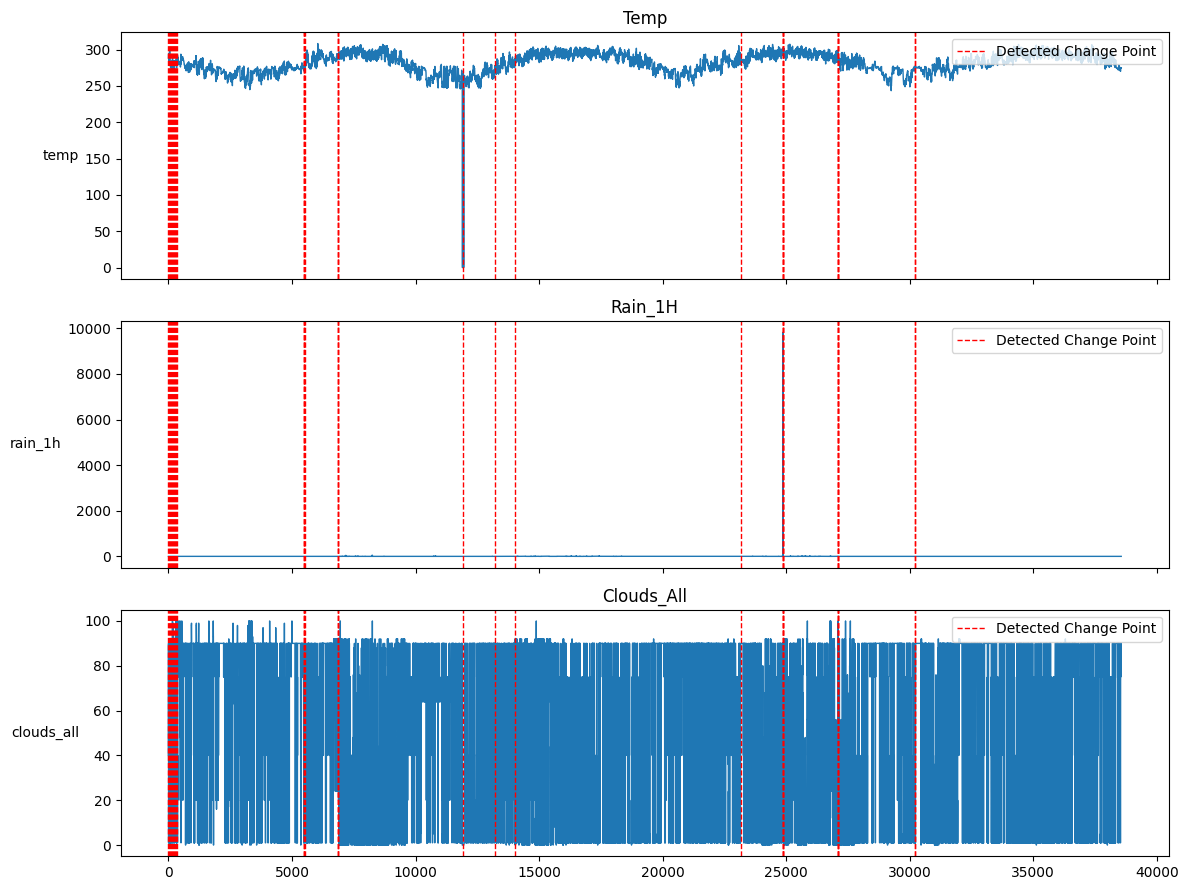

In [38]:
database_name = "UCI"
dataset_name = "METRO_TRAFFIC"
full_dataset_name = f"{database_name}_{dataset_name}"

df, variables = read_dataset(database_name, dataset_name)
train_val, test = split_train_test(df)
df = train_val.drop(columns=['ds'])

cpds = individual_metrics_dict[full_dataset_name][f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}"].to_list()

plot_change_points(df, variables, cpds, f"{full_dataset_name}_change_points.png")

## 4. ARR Rank

In [39]:
FIXED_APPROACHES = [
    'Fixed Cut 10%',
    'Fixed Cut 20%',
    'Fixed Cut 30%',
    'Fixed Cut 40%',
    'Fixed Cut 50%',
    'Fixed Cut 60%',
    'Fixed Cut 70%',
    'Fixed Cut 80%',
    'Fixed Cut 90%',
]

In [40]:
def compute_arr(df, acc_d, algorithm_p, algorithm_q, dataset, metric):
    df_d = df[df[DATASET_NAME_COL] == dataset]

    d_ap = df_d[df_d[CHANGE_POINT_APPROACH_COL] == algorithm_p]
    d_aq = df_d[df_d[CHANGE_POINT_APPROACH_COL] == algorithm_q]

    assert len(d_ap) == 1, f"Expected 1 line for approach {algorithm_p} but got {len(d_ap)}"
    assert len(d_aq) == 1, f"Expected 1 line for approach {algorithm_q} but got {len(d_aq)}"

    sr_ap = 1 / d_ap[metric].iloc[0]
    sr_aq = 1 / d_aq[metric].iloc[0]

    t_ap = d_ap[f"{ET_COL}_mean"].iloc[0]
    t_aq = d_aq[f"{ET_COL}_mean"].iloc[0]

    sr_ratio = sr_ap / sr_aq if sr_aq != 0 else np.nan  # Avoid division by zero
    time_ratio = np.log(t_ap / t_aq) if t_aq != 0 else np.nan  # Avoid division by zero

    arr = sr_ratio / (1 + acc_d * time_ratio)
    
    return arr


def compute_arr_ranking(df, acc_d, metric):
    algorithms = df[CHANGE_POINT_APPROACH_COL].unique()
    datasets = df[DATASET_NAME_COL].unique()
    arr_df = pd.DataFrame({
        DATASET_NAME_COL: [],
        'ap': [],
        'aq': [],
        'arr': [],
    })

    for dataset in datasets:
        for ap in algorithms:
            for aq in algorithms:
                if ap == aq:
                    continue

                arr_df = pd.concat([arr_df, pd.DataFrame({
                    DATASET_NAME_COL: [dataset],
                    'ap': [ap],
                    'aq': [aq],
                    'arr': [compute_arr(df, acc_d, ap, aq, dataset, metric)],
                })])

    grouped = arr_df.groupby(['ap', 'aq'])['arr'].apply(lambda x: np.prod(x) ** (1 / len(x))).reset_index()

    ranking_df = grouped.groupby('ap')['arr'].mean().reset_index()
    ranking_df['rank'] = ranking_df['arr'].rank(ascending=False, method='max')

    return ranking_df.sort_values(by='rank')

In [41]:
arr_rank_input_df = []
for dataset_name in DATASETS_NAMES:
    df = individual_metrics_dict[dataset_name][[
        DATASET_NAME_COL, CHANGE_POINT_APPROACH_COL,
        f"{RMSE_COL}_mean", f"{ET_COL}_mean"
    ]]
    df = df[~df[CHANGE_POINT_APPROACH_COL].isin(FIXED_APPROACHES)]
    arr_rank_input_df.append(df)
arr_rank_input_df = pd.concat(arr_rank_input_df, axis=0)

In [42]:
ACC_D_LIST = np.arange(0.1, 1.05, 0.1).tolist()
ACC_D_LIST = [round(acc_d, 2) for acc_d in ACC_D_LIST]
arr_rank_dict = dict()

In [43]:
arr_rank_df = []

for acc_d in ACC_D_LIST:
    key = f"{RMSE_COL}_mean_{acc_d}"
    arr_rank_dict[key] = compute_arr_ranking(
        arr_rank_input_df, acc_d=acc_d, metric=f"{RMSE_COL}_mean"
    )
    arr_rank_df_ = arr_rank_dict[key].rename(columns={
        'arr': f"arr_{acc_d}",
        'rank': f"rank_{acc_d}",
    })
    arr_rank_df.append(arr_rank_df_)

In [44]:
arr_rank_df = pd.concat(arr_rank_df, axis=1)
arr_rank_df = arr_rank_df.loc[:, ~arr_rank_df.columns.duplicated()]
arr_rank_df

ap   arr_0.1  rank_0.1   arr_0.2  rank_0.2   arr_0.3  \
20       Window RBF  1.098446       1.0  1.110893       2.0  1.131361   
16        Window L1  1.097961       2.0  1.121665       1.0  1.154176   
13    BottomUp Rank  1.077262       3.0  1.052875       9.0  1.033203   
7       BottomUp AR  1.067025       4.0  1.062093       7.0  1.062281   
8       BottomUp L1  1.061127       5.0  1.033909      11.0  1.011540   
15        Window AR  1.058852       6.0  1.064044       6.0  1.074792   
12     BottomUp RBF  1.054271       7.0  1.031550      13.0  1.013433   
17        Window L2  1.049645       8.0  1.069278       4.0  1.095474   
4     BinSeg Normal  1.041631       9.0  1.066599       5.0  1.101314   
11  BottomUp Normal  1.037745      10.0  1.077578       3.0  1.130725   
9       BottomUp L2  1.033536      11.0  1.056740       8.0  1.088795   
1         BinSeg L1  1.017693      12.0  0.995302      16.0  0.977592   
19    Window Normal  1.015544      13.0  1.032669      12.0  1.056652   
6       BinSeg Rank  1.012731      14.0  0.988815      18.0  0.969428   
14             Full  1.010160      15.0  0.952031      21.0  0.902430   
5        BinSeg RBF  1.006124      16.0  0.952970      20.0  0.908627   
3     BinSeg Linear  0.965559      17.0  0.996431      15.0  1.037379   
10  BottomUp Linear  0.951983      18.0  0.990833      17.0  1.046301   
21      Window Rank  0.930918      19.0  0.953998      19.0  0.990722   
2         BinSeg L2  0.889669      20.0  1.041343      10.0  1.396448   
0         BinSeg AR  0.876673      21.0  1.006207      14.0  1.222503   
18    Window Linear  0.854596      22.0  0.892967      22.0  0.947459   

    rank_0.3   arr_0.4  rank_0.4   arr_0.5  ...   arr_0.6  rank_0.6   arr_0.7  \
20       4.0  1.162654       5.0  1.217101  ...  1.215298      10.0  1.278569   
16       3.0  1.199155       4.0  1.272284  ...  1.282582       7.0  1.370233   
13      14.0  1.017446      16.0  1.005251  ...  0.996638      15.0  0.992152   
7       10.0  1.067926      13.0  1.080856  ...  1.109219      13.0  1.075581   
8       16.0  0.993087      18.0  0.978021  ...  0.966078      18.0  0.957219   
15       9.0  1.091708      11.0  1.117136  ...  1.161204      12.0  1.142494   
12      15.0  0.999114      17.0  0.988171  ...  0.980450      16.0  0.976050   
17       7.0  1.129768       9.0  1.176239  ...  1.252904       9.0  1.244205   
4        6.0  1.150521       6.0  1.228213  ...  1.255293       8.0  1.438292   
11       5.0  1.205959       3.0  1.338148  ...  1.402544       4.0  1.872520   
9        8.0  1.133540       7.0  1.201545  ...  1.366883       5.0  1.393560   
1       18.0  0.963739      19.0  0.953316  ...  0.946172      19.0  0.942422   
19      11.0  1.089437      12.0  1.135641  ...  1.210131      11.0  1.205354   
6       19.0  0.953725      20.0  0.941243  ...  0.931769      20.0  0.925320   
14      22.0  0.859453      22.0  0.821817  ...  0.788619      22.0  0.759211   
5       21.0  0.870900      21.0  0.838386  ...  0.810144      21.0  0.785540   
3       13.0  1.093463      10.0  1.179373  ...  1.648102       1.0  1.398453   
10      12.0  1.130097       8.0  1.296677  ...  1.583931       2.0  1.495961   
21      17.0  1.049541      14.0  1.170668  ...  1.331758       6.0  1.422313   
2        1.0  1.285008       2.0  1.027820  ...  1.032189      14.0  1.036752   
0        2.0  1.628471       1.0  0.976568  ...  0.974037      17.0  0.971646   
18      20.0  1.029612      15.0  1.189573  ...  1.440821       3.0  1.473912   

    rank_0.7   arr_0.8  rank_0.8   arr_0.9  rank_0.9   arr_1.0  rank_1.0  
20       9.0  1.387204       8.0  1.449823       6.0  1.667636       4.0  
16       8.0  1.524125       6.0  1.638212       3.0  1.805266       3.0  
13      15.0  0.993578      15.0  1.008325      15.0  0.945407      19.0  
7       13.0  1.094004      13.0  1.121168      13.0  1.162332      12.0  
8       18.0  0.951666      18.0  0.950032      18.0  0.953713      18.0  
15      12.0  1.183496 

In [45]:
arr_rank_df.to_excel(f"{OUTPUT_FOLDER}/ARR_Rank.xlsx", index=False)

## 5. Significance Test for Individual Metrics

In [46]:
def get_friedman_significance(df, col_starts_with):
    metric_columns = [col for col in df.columns if col.startswith(col_starts_with)]
    results = {str(df[CHANGE_POINT_APPROACH_COL].iloc[i]): df[metric_columns].iloc[i].values for i in range(len(df))}

    data = pd.DataFrame(results).T
    data.columns = metric_columns

    friedman_stat, p_value = stats.friedmanchisquare(*[data[col] for col in data.columns])
    print(f"Friedman Test Statistic: {friedman_stat:.10f}")
    print(f"p-value: {p_value:.20f}")

    if p_value < 0.05:
        print("Statistically significant differences detected between methods.")    

    else:
        print("No statistically significant difference between methods.")

### 5.1. [UCI] Air Quality

#### 5.1.1. RMSE

In [47]:
dataset_name = "UCI_AIR_QUALITY"
get_friedman_significance(
    individual_metrics_dict[dataset_name], col_starts_with=f"{RMSE_COL}_seed_"
)

Friedman Test Statistic: 35.9225806452
p-value: 0.00000030017782944748
Statistically significant differences detected between methods.


#### 5.1.2. ET

In [48]:
dataset_name = "UCI_AIR_QUALITY"
get_friedman_significance(
    individual_metrics_dict[dataset_name], col_starts_with=f"{ET_COL}_seed_"
)

Friedman Test Statistic: 92.1548387097
p-value: 0.00000000000000000046
Statistically significant differences detected between methods.


### 5.2. [UCI] PM2.5 BEIJING

#### 5.2.1. RMSE

In [49]:
dataset_name = "UCI_PRSA_BEIJING"
get_friedman_significance(
    individual_metrics_dict[dataset_name], col_starts_with=f"{RMSE_COL}_seed_"
)

Friedman Test Statistic: 29.6542810985
p-value: 0.00000575515647584341
Statistically significant differences detected between methods.


#### 5.2.2. ET

In [50]:
dataset_name = "UCI_PRSA_BEIJING"
get_friedman_significance(
    individual_metrics_dict[dataset_name], col_starts_with=f"{ET_COL}_seed_"
)

Friedman Test Statistic: 86.5806451613
p-value: 0.00000000000000000701
Statistically significant differences detected between methods.


### 5.3. [UCI] Appliances Energy

#### 5.3.1. RMSE

In [51]:
dataset_name = "UCI_APPLIANCES_ENERGY"
get_friedman_significance(
    individual_metrics_dict[dataset_name], col_starts_with=f"{RMSE_COL}_seed_"
)

Friedman Test Statistic: 48.3554119548
p-value: 0.00000000079574124035
Statistically significant differences detected between methods.


#### 5.3.2. ET

In [52]:
dataset_name = "UCI_APPLIANCES_ENERGY"
get_friedman_significance(
    individual_metrics_dict[dataset_name], col_starts_with=f"{ET_COL}_seed_"
)

Friedman Test Statistic: 98.0387096774
p-value: 0.00000000000000000003
Statistically significant differences detected between methods.


### 5.4. [UCI] Metro Traffic

#### 5.4.1. RMSE

In [53]:
dataset_name = "UCI_METRO_TRAFFIC"
get_friedman_significance(
    individual_metrics_dict[dataset_name], col_starts_with=f"{RMSE_COL}_seed_"
)

Friedman Test Statistic: 13.8731707317
p-value: 0.00771103979162543907
Statistically significant differences detected between methods.


#### 5.4.2. ET

In [54]:
dataset_name = "UCI_METRO_TRAFFIC"
get_friedman_significance(
    individual_metrics_dict[dataset_name], col_starts_with=f"{ET_COL}_seed_"
)

Friedman Test Statistic: 83.5870967742
p-value: 0.00000000000000003025
Statistically significant differences detected between methods.


## 6. Plot Critical Difference Diagram

In [55]:
def get_cd_diagram(metric_name, file_name, maximize_outcome=True):
    cd_df = []
    for dataset_name in DATASETS_NAMES:
        df = individual_metrics_dict[dataset_name][[CHANGE_POINT_APPROACH_COL, metric_name]]
        df = df[~df[CHANGE_POINT_APPROACH_COL].isin(FIXED_APPROACHES)]
        df[DATASET_NAME_COL] = dataset_name
        df = df.rename(columns={
            CHANGE_POINT_APPROACH_COL: 'classifier_name',
            metric_name: 'accuracy',
        })
        cd_df.append(df)

    cd_df = pd.concat(cd_df, axis=0)

    cd_df = cd_df[['classifier_name', 'dataset_name', 'accuracy']]
    cd_df = cd_df.reset_index(drop=True)

    cd_df = cd_df.pivot(
        index = "dataset_name",
        columns = "classifier_name",
        values = "accuracy"
    )

    diagram = Diagram(
        cd_df.to_numpy(),
        treatment_names = cd_df.columns,
        maximize_outcome=maximize_outcome
    )

    diagram.average_ranks
    diagram.get_groups(alpha=.05, adjustment="holm")

    diagram.to_file(
        f"{OUTPUT_FOLDER}/{file_name}",
        alpha = .05,
        adjustment = "holm",
        reverse_x = True,
        axis_options = {"title": "critdd"}
    )

    return diagram

### 6.1. RMSE

In [56]:
diagram = get_cd_diagram(f"{RMSE_COL}_mean", "cd_diagram_rmse.tex", maximize_outcome=False)

### 6.2. ET

In [57]:
diagram = get_cd_diagram(f"{ET_COL}_mean", "cd_diagram_et.tex", maximize_outcome=False)

## 7. Comparison

In [58]:
def plot_scatter_plot(df, filename=None):
    plt.figure(figsize=(10, 6))
    
    scatter = plt.scatter(
        df[RMSE_COL],
        df[ET_MIN_COL],
        c=df[CHANGE_POINT_PERC_COL],
        cmap="viridis_r",
        s=100,
        alpha=0.8,
        edgecolors="k"
    )

    cbar = plt.colorbar(scatter)
    cbar.set_label("Change Point %")

    texts = []
    for i, row in df.iterrows():
        texts.append(
            plt.text(
                row[RMSE_COL],
                row[ET_MIN_COL],
                row[CHANGE_POINT_APPROACH_COL],
                fontsize=9
            )
        )

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    plt.xlabel("Average RMSE")
    plt.ylabel("Execution Time (minutes)")
    plt.title("")
    plt.grid(True)
    plt.tight_layout()

    if filename:
        plt.savefig(f"{OUTPUT_FOLDER}/{filename}", dpi=300, bbox_inches='tight')

    plt.show()

In [59]:
comp_df = []

for dataset_name in DATASETS_NAMES:
    df = individual_metrics_dict[dataset_name][[
        CHANGE_POINT_APPROACH_COL, f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}", f"{RMSE_COL}_mean", f"{ET_MIN_COL}_mean"
    ]]
    df = df[~df[CHANGE_POINT_APPROACH_COL].isin(FIXED_APPROACHES)]
    df[DATASET_NAME_COL] = dataset_name
    comp_df.append(df)

comp_df = pd.concat(comp_df, axis=0)

### 7.1. [UCI] Air Quality

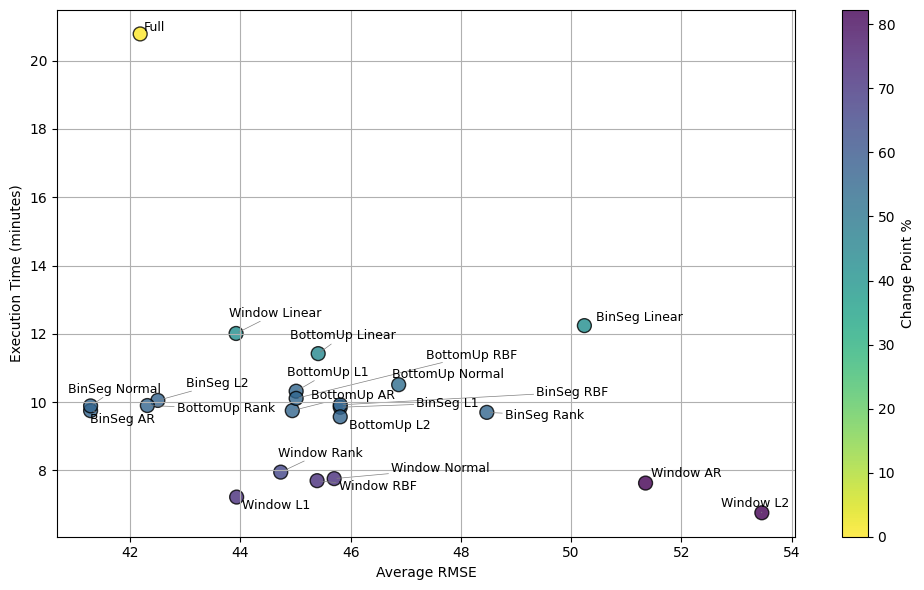

In [60]:
dataset = "UCI_AIR_QUALITY"
df = comp_df[comp_df["dataset_name"] == dataset]
df = df.rename(columns={
    f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}": CHANGE_POINT_PERC_COL,
    f"{RMSE_COL}_mean": RMSE_COL,
    f"{ET_MIN_COL}_mean": ET_MIN_COL,
})

plot_scatter_plot(df, f"{dataset}_scatter_plot.png")

### 7.2. [UCI] PM2.5 BEIJING

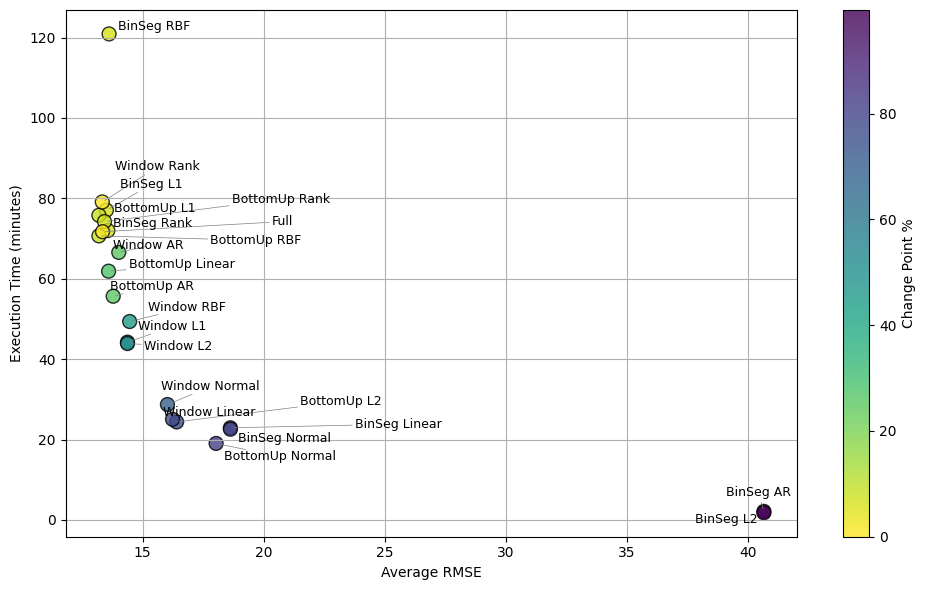

In [61]:
dataset = "UCI_PRSA_BEIJING"
df = comp_df[comp_df["dataset_name"] == dataset]
df = df.rename(columns={
    f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}": CHANGE_POINT_PERC_COL,
    f"{RMSE_COL}_mean": RMSE_COL,
    f"{ET_MIN_COL}_mean": ET_MIN_COL,
})

plot_scatter_plot(df, f"{dataset}_scatter_plot.png")

### 7.3. [UCI] Appliances Energy

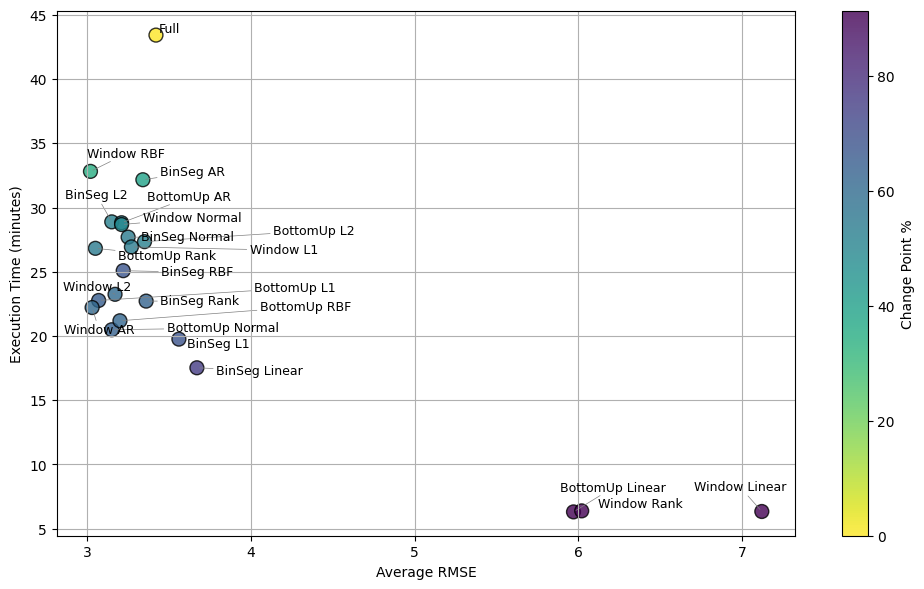

In [62]:
dataset = "UCI_APPLIANCES_ENERGY"
df = comp_df[comp_df["dataset_name"] == dataset]
df = df.rename(columns={
    f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}": CHANGE_POINT_PERC_COL,
    f"{RMSE_COL}_mean": RMSE_COL,
    f"{ET_MIN_COL}_mean": ET_MIN_COL,
})

plot_scatter_plot(df, f"{dataset}_scatter_plot.png")

### 7.4. [UCI] Metro Traffic

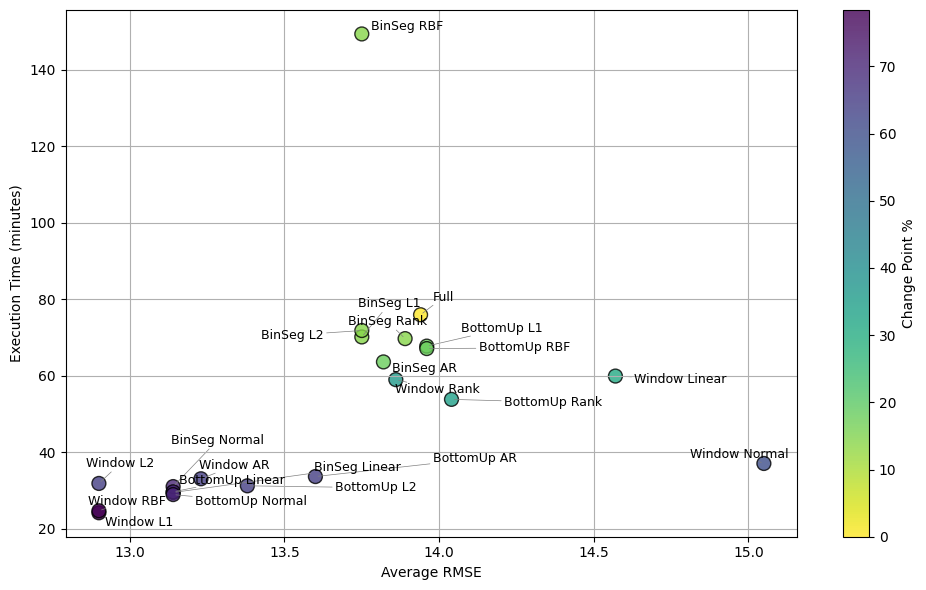

In [63]:
dataset = "UCI_METRO_TRAFFIC"
df = comp_df[comp_df["dataset_name"] == dataset]
df = df.rename(columns={
    f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}": CHANGE_POINT_PERC_COL,
    f"{RMSE_COL}_mean": RMSE_COL,
    f"{ET_MIN_COL}_mean": ET_MIN_COL,
})

plot_scatter_plot(df, f"{dataset}_scatter_plot.png")

### 7.5 Combined

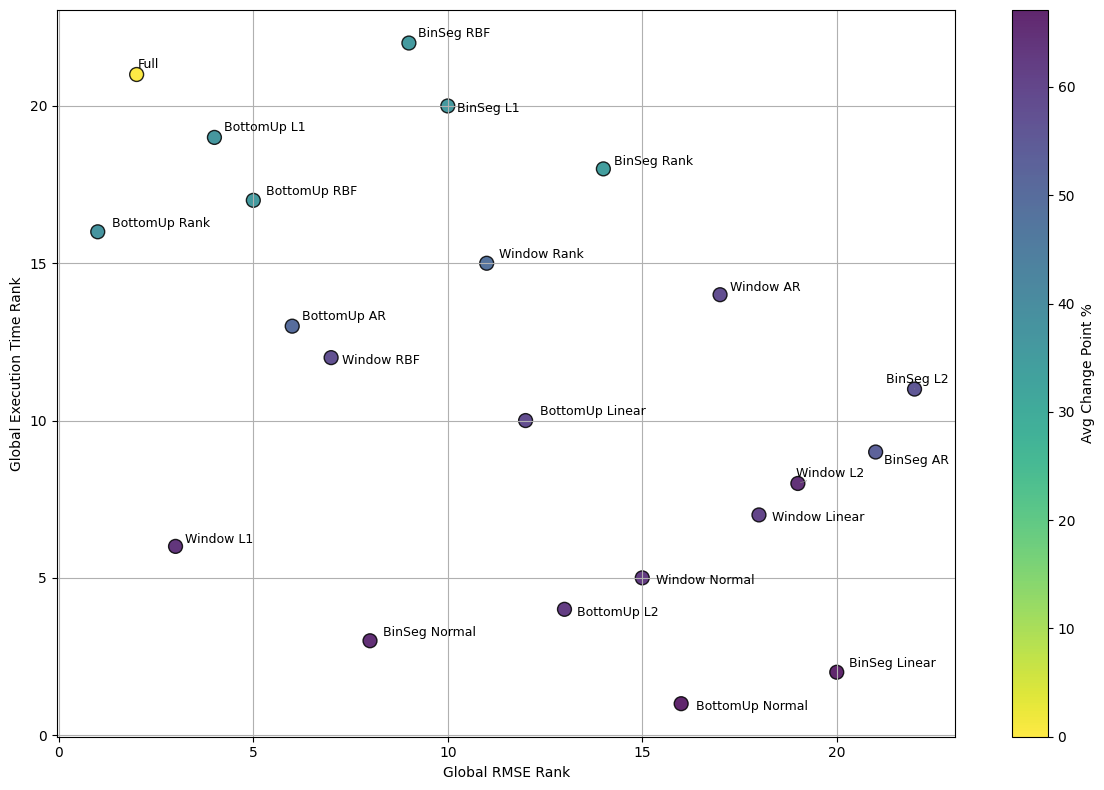

<Figure size 640x480 with 0 Axes>

In [64]:
agg_df = comp_df.groupby("change_point_approach").agg({
    f"{RMSE_COL}_mean": "mean",
    f"{ET_MIN_COL}_mean": "mean",
    f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}": "mean"
}).reset_index()

agg_df["RMSE_rank"] = agg_df[f"{RMSE_COL}_mean"].rank(ascending=True)
agg_df["ExecTime_rank"] = agg_df[f"{ET_MIN_COL}_mean"].rank(ascending=True)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    agg_df["RMSE_rank"],
    agg_df["ExecTime_rank"],
    c=agg_df[f"{CHANGE_POINT_PERC_COL}_seed_{SEEDS[0]}"],
    cmap="viridis_r",
    s=100,
    alpha=0.85,
    edgecolors="k"
)

cbar = plt.colorbar(scatter)
cbar.set_label("Avg Change Point %")

texts = []
for _, row in agg_df.iterrows():
    texts.append(
        plt.text(
            row["RMSE_rank"],
            row["ExecTime_rank"],
            row["change_point_approach"],
            fontsize=9
        )
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.xlabel("Global RMSE Rank")
plt.ylabel("Global Execution Time Rank")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig(f"{OUTPUT_FOLDER}/agg_scatter_plot.png", dpi=300, bbox_inches='tight')